# ML Pipeline

## Data Preparation

In [1]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

from datetime import date

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

import pickle
import json




Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Extracting refined dataset from Google Storage Bucket

In [2]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [3]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/03_refined/df_windowed_full.parquet"
base_dataset =  pd.read_parquet(path)

df = base_dataset.copy()

In [4]:
df[['Papel','Tipo','Setor','Subsetor']]

Papel Tipo                       Setor              Subsetor
24     ABCB4   PN  Intermediários Financeiros                Bancos
25     ABCB4   PN  Intermediários Financeiros                Bancos
26     ABCB4   PN  Intermediários Financeiros                Bancos
27     ABCB4   PN  Intermediários Financeiros                Bancos
28     ABCB4   PN  Intermediários Financeiros                Bancos
...      ...  ...                         ...                   ...
91432  ORVR3   ON           Água e Saneamento     Água e Saneamento
91457  POWE3   ON            Energia Elétrica      Energia Elétrica
91458  POWE3   ON            Energia Elétrica      Energia Elétrica
91483  WEST3   ON        Programas e Serviços  Programas e Serviços
91484  WEST3   ON        Programas e Serviços  Programas e Serviços

[76852 rows x 4 columns]

In [5]:
df = df[df.columns.sort_values()]

In [6]:
df.shape

(76852, 312)

In [7]:
[col for col in df.columns if 'category' in col]

['Lucro_Liquido_12m_category']

## Select Features

In [8]:
features = [
                'Empresa', 'Papel',
                'year_last', 'month_last',
                'besst_1', 'besst_2',
                'Setor','Tipo',
                'Lucro_Liquido_12m_category',
                # 'Valor_de_mercado_category',
                # 'Patrim_Liq_category',
                'dy_label',
                'dy_median_last', 'dy_median_max','dy_median_min','dy_spread','dy_mean_std','dy_mean_last', 'dy_median_ref_min',#add dy relativo
                'euro_last','euro_mean', #add euro relativo
                'evebit_mean_ref_mean','evebit_mean_last','evebit_mean_mean', #add evebit relativo
                'c5y_mean_last','c5y_mean_mean', #add c5y relativo
                'cotacao_max_ref_max','cotacao_mean_ref_mean','cotacao_mean_ref_std', 'cotacao_mean_last', 'cotacao_mean_mean',#add cotacao relativo
                'divbpatr_max_ref_max','divbpatr_mean_last','divbpatr_mean_mean', #add divbpatr relativo
                'dolar_comercial_last','dolar_comercial_mean', #add euro relativo
                'ibovespa_spread','ibovespa_spread_relevance','ibovespa_last','ibovespa_mean',#add ibovespa relativo
                'pib_dolarizado_last','pib_dolarizado_mean', #add pib_dolarizado relativo
                'preco_do_petroleo_last','preco_do_petroleo_mean', #add preco_do_petroleo relativo
                'igpm_last','igpm_mean',#add igpm relativo
                'ipca_last','ipca_mean',#add ipca relativo
                'selic_last','selic_mean',#add igpm relativo
                'liq2m_mean_ref_mean','liq2m_mean_last','liq2m_mean_mean', #add liq2m relativo
                'liqc_mean_ref_mean','liqc_mean_last','liqc_mean_mean', #add liqc relativo
                'mrgebit_mean_ref_mean','mrgebit_mean_last','mrgebit_mean_mean', #add mrgebit relativo
                'mrgliq_mean_ref_mean','mrgliq_mean_last','mrgliq_mean_mean', #add mrgliq relativo
                'pa_mean_ref_mean','pa_mean_last', 'pa_mean_mean',#add pa relativo
                'pl_mean_ref_mean','pl_mean_last', 'pl_mean_mean',#add pa relativo
                'pcg_mean_ref_mean','pcg_mean_last', 'pcg_mean_mean',#add pcg relativo
                'pebit_mean_ref_mean','pebit_mean_last', 'pebit_mean_mean',#add pebit relativo
                'pacl_mean_ref_mean','pacl_mean_last', 'pacl_mean_mean',#add pacl relativo
                'psr_mean_ref_mean','psr_mean_last', 'psr_mean_mean',#add psr relativo
                'pvp_mean_ref_mean','pvp_mean_last', 'pvp_mean_mean',#add pvp relativo
                'roe_mean_ref_mean','roe_mean_last', 'roe_mean_mean',#add roe relativo
                'roic_mean_ref_mean','roic_mean_last', 'roic_mean_mean',#add roic relativo
                'patrliq_mean_ref_mean','patrliq_mean_last','patrliq_mean_mean', #add patrliq relativo
            ]

roots = [
            'euro',
            'dy_mean',
            'evebit_mean',
            'c5y_mean',
            'cotacao_mean',
            'divbpatr_mean',
            'dolar_comercial',
            'ibovespa',
            'pib_dolarizado',
            'preco_do_petroleo',
            'igpm',
            'ipca',
            'selic',
            'liq2m',
            'liqc',
            'mrgebit',
            'mrgliq',
            'pa_mean',
            'pl_mean',
            'pcg_mean',
            'pebit_mean',
            'pacl_mean',
            'psr_mean',
            'pvp_mean',
            'roe_mean',
            'roic_mean_last',
            'patrliq_mean'
        ]

setor_encoding = {
    'Computadores e Equipamentos':1,
    'Tecidos, Vestuário e Calçados':2,
    'Máquinas e Equipamentos':3,
    'Equipamentos':4,
    'Automóveis e Motocicletas':5,
    'Bebidas':6,
    'Alimentos Processados':7,
    'Produtos de Uso Pessoal e de Limpeza':8,
    'Utilidades Domésticas':9,
    'Embalagens':10,
    'Materiais Diversos':11,
    'Medicamentos e Outros Produtos':12,
    'Serv.Méd.Hospit. Análises e Diagnósticos':13,
    'Hoteis e Restaurantes':14,
    'Viagens e Lazer':15,
    'Transporte':16,
    'Material de Transporte':17,
    'Serviços Diversos':18,
    'Programas e Serviços':19,
    'Comércio e Distribuição':20,
    'Comércio':21,
    'Telecomunicações':22,
    'Mídia':23,
    'Holdings Diversificadas':24,
    'Serviços Financeiros Diversos':25,
    'Intermediários Financeiros':26,
    'Previdência e Seguros':27,
    'Exploração de Imóveis':28,
    'Químicos':29,
    'Construção e Engenharia':30,
    'Construção Civil':31,
    'Siderurgia e Metalurgia':32,
    'Energia Elétrica':33,
    'Água e Saneamento':34,
    'Gás':35,
    'Petróleo, Gás e Biocombustíveis':36,
    'Mineração':37,
    'Madeira e Papel':38,
    'Agropecuária':39,
    'Diversos':40,
    'Outros':41,
}

In [9]:
df['dy_mean_std'].min()

0.0

In [10]:
df['dy_mean_std'][((df['dy_mean_std']<=0.005)&(df['dy_median_min']<=0.005))]

234      0.001149
235      0.001131
236      0.001124
237      0.001109
238      0.001115
           ...   
91432    0.000000
91457    0.000984
91458    0.000963
91483    0.000000
91484    0.000000
Name: dy_mean_std, Length: 33450, dtype: float64

In [11]:
df['dy_mean_std'][((df['dy_mean_std']<=0.005)&(df['dy_median_min']<=0.005))] = df['dy_mean_std'].max()

In [12]:
df = df[features]

df['encoded_sectors']    = df['Setor'].replace(setor_encoding)

df['power_valuation']    = df['roe_mean_last']*df['roic_mean_last']*df['roe_mean_mean']*df['roe_mean_mean']
df['power_price']        = df['pvp_mean_last']*df['psr_mean_last']*df['pacl_mean_last']*df['pl_mean_last']*df['pa_mean_last']
df['power_price']        = (df['pl_mean_last']*df['pa_mean_last'])/(df['pl_mean_ref_mean']*df['pa_mean_ref_mean'])
df['power_margin']       = df['mrgliq_mean_last']/1_000_000*df['mrgebit_mean_last']/1_000_000
df['power_buy_flag']     = (df['pl_mean_last']*df['dy_median_last']*df['dy_median_min'])
df['power_stabil']       = df['dy_median_min']/df['dy_mean_std']
df['power_stabil_delta'] = (df['dy_median_max'] - df['dy_median_min'])/df['dy_mean_std']
df['power_min']          = df['dy_median_min']*df['dy_median_ref_min']

In [13]:
def create_trends(data,roots):
    
    data_out = data.copy()
    for root in roots:
        try:
            data_out[root + '_trend'] = (np.divide(data_out[root + '_last'],data_out[root + '_mean'])-1)*100
        except:
            continue
    return data_out



df = create_trends(df,roots)

In [14]:
df[df.columns[df.dtypes=='float64']].max().sort_values(ascending=False)[:50].index

Index(['liq2m_mean_ref_mean', 'patrliq_mean_ref_mean', 'patrliq_mean_mean',
       'patrliq_mean_last', 'power_valuation', 'liq2m_mean_last',
       'liq2m_mean_mean', 'pl_mean_ref_mean', 'evebit_mean_last',
       'pl_mean_last', 'pebit_mean_last', 'evebit_mean_mean', 'pl_mean_mean',
       'pebit_mean_mean', 'patrliq_mean_trend', 'psr_mean_ref_mean',
       'pebit_mean_ref_mean', 'pl_mean_trend', 'evebit_mean_ref_mean',
       'pcg_mean_ref_mean', 'psr_mean_trend', 'pcg_mean_last', 'power_min',
       'pebit_mean_trend', 'pcg_mean_trend', 'pcg_mean_mean',
       'pacl_mean_trend', 'pvp_mean_trend', 'power_price',
       'mrgebit_mean_ref_mean', 'psr_mean_last', 'evebit_mean_trend',
       'divbpatr_mean_trend', 'psr_mean_mean', 'pacl_mean_ref_mean',
       'pacl_mean_last', 'ibovespa_spread', 'ibovespa_mean', 'ibovespa_last',
       'pa_mean_trend', 'mrgliq_mean_ref_mean', 'roe_mean_ref_mean',
       'pvp_mean_last', 'pacl_mean_mean', 'roic_mean_ref_mean',
       'pvp_mean_mean', 'ro

In [15]:
def transform_dummy(data, features):
    """
    Transform categorical values into numerical values using one-hot encoding.
    
    Parameters:
        data (DataFrame): The DataFrame containing the categorical features to be transformed.
        features (list): List of categorical features to be transformed.
        
    Returns:
        DataFrame: The transformed DataFrame with numerical values for categorical features.
    """
    for feature in features:
        # Generate one-hot encoded columns and append to the DataFrame
        one_hot_encoded = pd.get_dummies(data[feature])
        new_columns = [(str(feature) + '_' + str(col)) for col in one_hot_encoded.columns]
        data[new_columns] = one_hot_encoded
        
        # Drop the original categorical feature from the DataFrame
        data.drop(feature, axis=1, inplace=True)
        
    return data

In [16]:
def column_name_cleaner(col):
    """
    Clean column names by replacing non-UTF-8 characters with a replacement character.

    Parameters:
        col (str): The column name to be cleaned.

    Returns:
        str: The cleaned column name.
    """
    return col.encode('utf-8', 'replace').decode('utf-8')


In [17]:
def create_year_month_column(data: pd.DataFrame, year_column: str, month_column: str) -> pd.DataFrame:
    """
    Create a new column 'year_month' in the DataFrame by concatenating values from two columns.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the columns 'year_last' and 'month_last'.
        year_column (str): Name of the column containing the year values.
        month_column (str): Name of the column containing the month values.

    Returns:
        pd.DataFrame: The DataFrame with a new 'year_month' column.
    """
    # Ensure that the specified columns exist in the DataFrame
    if year_column not in data.columns or month_column not in data.columns:
        raise ValueError(f"Columns '{year_column}' and '{month_column}' not found in the DataFrame.")
    
    # Create the 'year_month' column by concatenating the values from 'year_last' and 'month_last' columns
    data['year_month'] = data[year_column].astype(str) + data[month_column].astype(str)
    
    return data

In [18]:
df.columns = [column_name_cleaner(col) for col in df.columns]

df = create_year_month_column(df, 'year_last', 'month_last')


In [19]:
object_cols = df.columns[df.dtypes == 'object'] 
print(object_cols)

Index(['Empresa', 'Papel', 'Setor', 'Tipo', 'year_month'], dtype='object')


In [20]:
bool_cols = df.columns[df.dtypes == 'bool'] 
print(bool_cols)

Index(['besst_1', 'besst_2'], dtype='object')


In [21]:
df.columns[df.dtypes=='float64'][(df[df.columns[df.dtypes=='float64']].max()>1_000_000_000_000)]

Index(['liq2m_mean_ref_mean', 'patrliq_mean_ref_mean'], dtype='object')

In [22]:
# dropping columns with maximum values larger than 1 trillion dollars
to_drop = df.columns[df.dtypes=='float64'][(df[df.columns[df.dtypes=='float64']].max()>1_000_000_000_000)]
df = df.drop(to_drop, axis=1)

In [23]:
df[to_drop].max()

liq2m_mean_ref_mean      8.697993e+38
patrliq_mean_ref_mean    1.410626e+12
dtype: float64

In [24]:
# transforming bool_cols to float
df[bool_cols] = df[bool_cols].astype('float64')

In [25]:
# checking NaN values and inputing median
df.isna().mean().sort_values(ascending=False)[:30]

divbpatr_mean_trend    0.135221
psr_mean_trend         0.110355
pacl_mean_trend        0.105345
pcg_mean_trend         0.105345
evebit_mean_trend      0.103498
pebit_mean_trend       0.101663
power_price            0.101663
pa_mean_trend          0.096068
c5y_mean_trend         0.016083
roe_mean_trend         0.005595
pl_mean_trend          0.005595
psr_mean_mean          0.000000
pacl_mean_mean         0.000000
psr_mean_ref_mean      0.000000
psr_mean_last          0.000000
Empresa                0.000000
pvp_mean_ref_mean      0.000000
pvp_mean_last          0.000000
pacl_mean_last         0.000000
roe_mean_ref_mean      0.000000
roe_mean_last          0.000000
pvp_mean_mean          0.000000
pebit_mean_last        0.000000
pacl_mean_ref_mean     0.000000
pebit_mean_mean        0.000000
roic_mean_ref_mean     0.000000
pebit_mean_ref_mean    0.000000
pcg_mean_mean          0.000000
pcg_mean_last          0.000000
pcg_mean_ref_mean      0.000000
dtype: float64

In [26]:
# inpute 0 for missing values
df.fillna(0, inplace=True)

In [27]:
df = transform_dummy(df,['Tipo'])

In [28]:
cor = df.corr()['dy_label']

<AxesSubplot:>

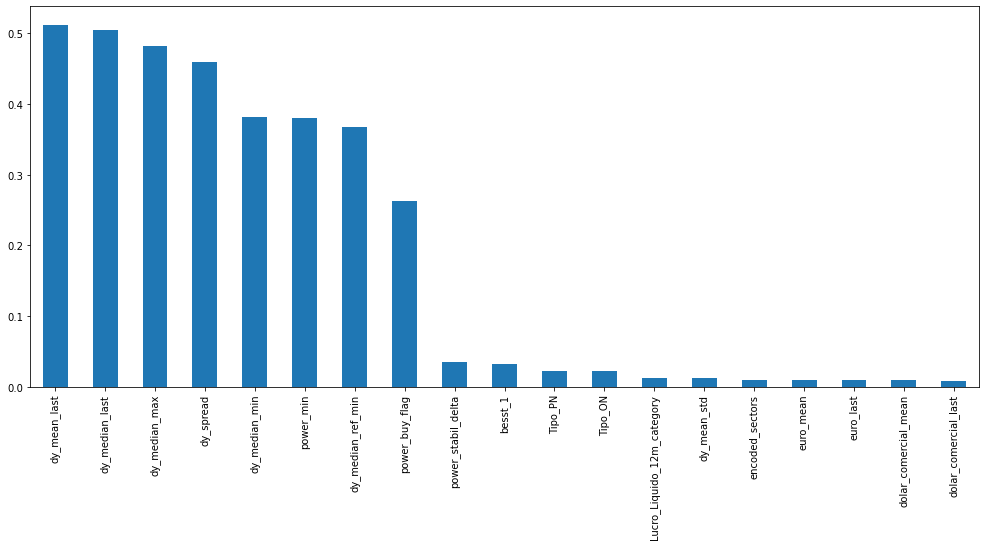

In [29]:
plt.figure(figsize=(17,7))
np.abs(cor).sort_values(ascending=False)[1:20].plot(kind='bar')

In [30]:
training_cols = np.abs(cor).sort_values(ascending=False)[0:150].index

In [31]:
df_to_train = df[['Empresa', 'Papel', 'year_month'] + list(training_cols)].copy()

In [32]:
df_to_train.sort_values(by='year_month', ascending=False)

Empresa  Papel  year_month  dy_label  \
91484                 WESTWING ON NM  WEST3   2022.04.0  0.000000   
56359                   PETTENATI PN  PTNT4   2022.04.0  0.045183   
56001              PORTOBELLO S/A PN  PTBL4   2022.04.0  0.000007   
68790                    Tegma ON NM  TGMA3   2022.04.0  0.056549   
45199             LOPES BRASIL ON NM  LPSB3   2022.04.0  0.002627   
...                              ...    ...         ...       ...   
45586    TREVISA INVESTIMENTOS SA ON  LUXM3  2009.010.0  0.000000   
12379  BR MALLS PARTICIPAÇÔES S/A ON  BRML3  2009.010.0  0.005625   
16767                     COELBA PNA  CEEB5  2009.010.0  0.144415   
67566                   TEKA S.A. PN  TEKA4  2009.010.0  0.000000   
70788              UNIBANCO SA PN N1  UBBR4  2009.010.0  0.024803   

       dy_mean_last  dy_median_last  dy_median_max  dy_spread  dy_median_min  \
91484      0.000000        0.000000       0.000000   0.000000       0.000000   
56359      0.047450        0.047450       0.050134   0.028300       0.047664   
56001      0.000000        0.000000       0.000000   0.000000       0.000000   
68790      0.072385        0.072384       0.091556   0.037475       0.073896   
45199      0.003799        0.003799       0.005707   0.045534       0.003933   
...             ...             ...            ...        ...            ...   
45586     37.372012       37.495189      36.759552  37.470272       0.000000   
12379      0.006636        0.006636       0.007759   0.007807       0.006725   
16767      0.115561        0.115560       0.113282   0.036268       0.089044   
67566      0.000000        0.000000       0.000000   0.000000       0.000000   
70788      0.018969        0.018968       0.018493   0.018719       0.013634   

       power_min  dy_median_ref_min  power_buy_flag  power_stabil_delta  \
91484   0.000000           0.000000        0.000000            0.000000   
56359   0.000000           0.000000        0.007815            2.513153   
56001   0.000000           0.000000        0.000000            0.000000   
68790   0.000000           0.000000        0.049801            3.110346   
45199   0.002664           0.677500        0.000074            0.000006   
...          ...                ...             ...                 ...   
45586   0.000000           0.000000       -0.000000            2.788447   
12379   0.001898           0.282218        0.002178            1.984922   
16767   0.097453           1.094445        0.069779            3.039563   
67566   0.000000           0.000000       -0.000000            0.000000   
70788   0.003689           0.270592        0.096995            3.880826   

       besst_1  Tipo_PN  Tipo_ON  Lucro_Liquido_12m_category  dy_mean_std  \
91484      0.0        0        1                         1.0   312.472845   
56359      0.0        1        0                         4.0     0.000983   
56001      0.0        1        0                         6.0   312.472845   
68790      0.0        0        1                         6.0     0.005678   
45199      0.0        0        1                         3.0   312.472845   
...        ...      ...      ...                         ...          ...   
45586      0.0        0        1                         3.0    13.182803   
12379      0.0        0        1                         7.0     0.000521   
16767      1.0        1        0                         9.0     0.007974   
67566      0.0        1        0                         1.0   312.472845   
70788      1.0        1        0                         4.0     0.001252   

       encoded_sectors  euro_mean  euro_last  dolar_comercial_mean  \
91484               19   4.469975    5.18520              4.318067   
56359                2   4.469975    5.18520              4.318067   
56001               30   4.469975    5.18520              4.318067   
68790               16   4.469975    5.18520              4.318067   
45199               28   4.469975    5.18520              4.318

In [33]:
df_to_pred  = df_to_train[df_to_train['year_month']=='2022.04.0'].copy()
df = df_to_train[df_to_train['year_month']!='2022.04.0']

In [34]:
df['dy_label']

24       0.081976
25       0.081300
26       0.080631
27       0.079991
28       0.079338
           ...   
91379    0.000000
91405    0.000000
91431    0.000000
91457    0.000000
91483    0.000000
Name: dy_label, Length: 76247, dtype: float64

In [101]:
df.isna().mean()

Empresa                   0.0
Papel                     0.0
year_month                0.0
dy_label                  0.0
dy_mean_last              0.0
                         ... 
ibovespa_last             0.0
pib_dolarizado_last       0.0
preco_do_petroleo_last    0.0
igpm_last                 0.0
ipca_last                 0.0
Length: 120, dtype: float64

#### Spliting data into training a test data

features X_train: 116
features X_test: 116



5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Pontello\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Pontello\anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\Pontello\anaconda3\lib\site-packages\xgboost\sklearn.py", line 988, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\Users\Pontello\anaconda3\lib\site-packages\xgboost\sklearn.py", line 448, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(


R2 score: nan
Mean squared error: nan
test score: 0.4405176813855648 
train score: 0.9998446717760584


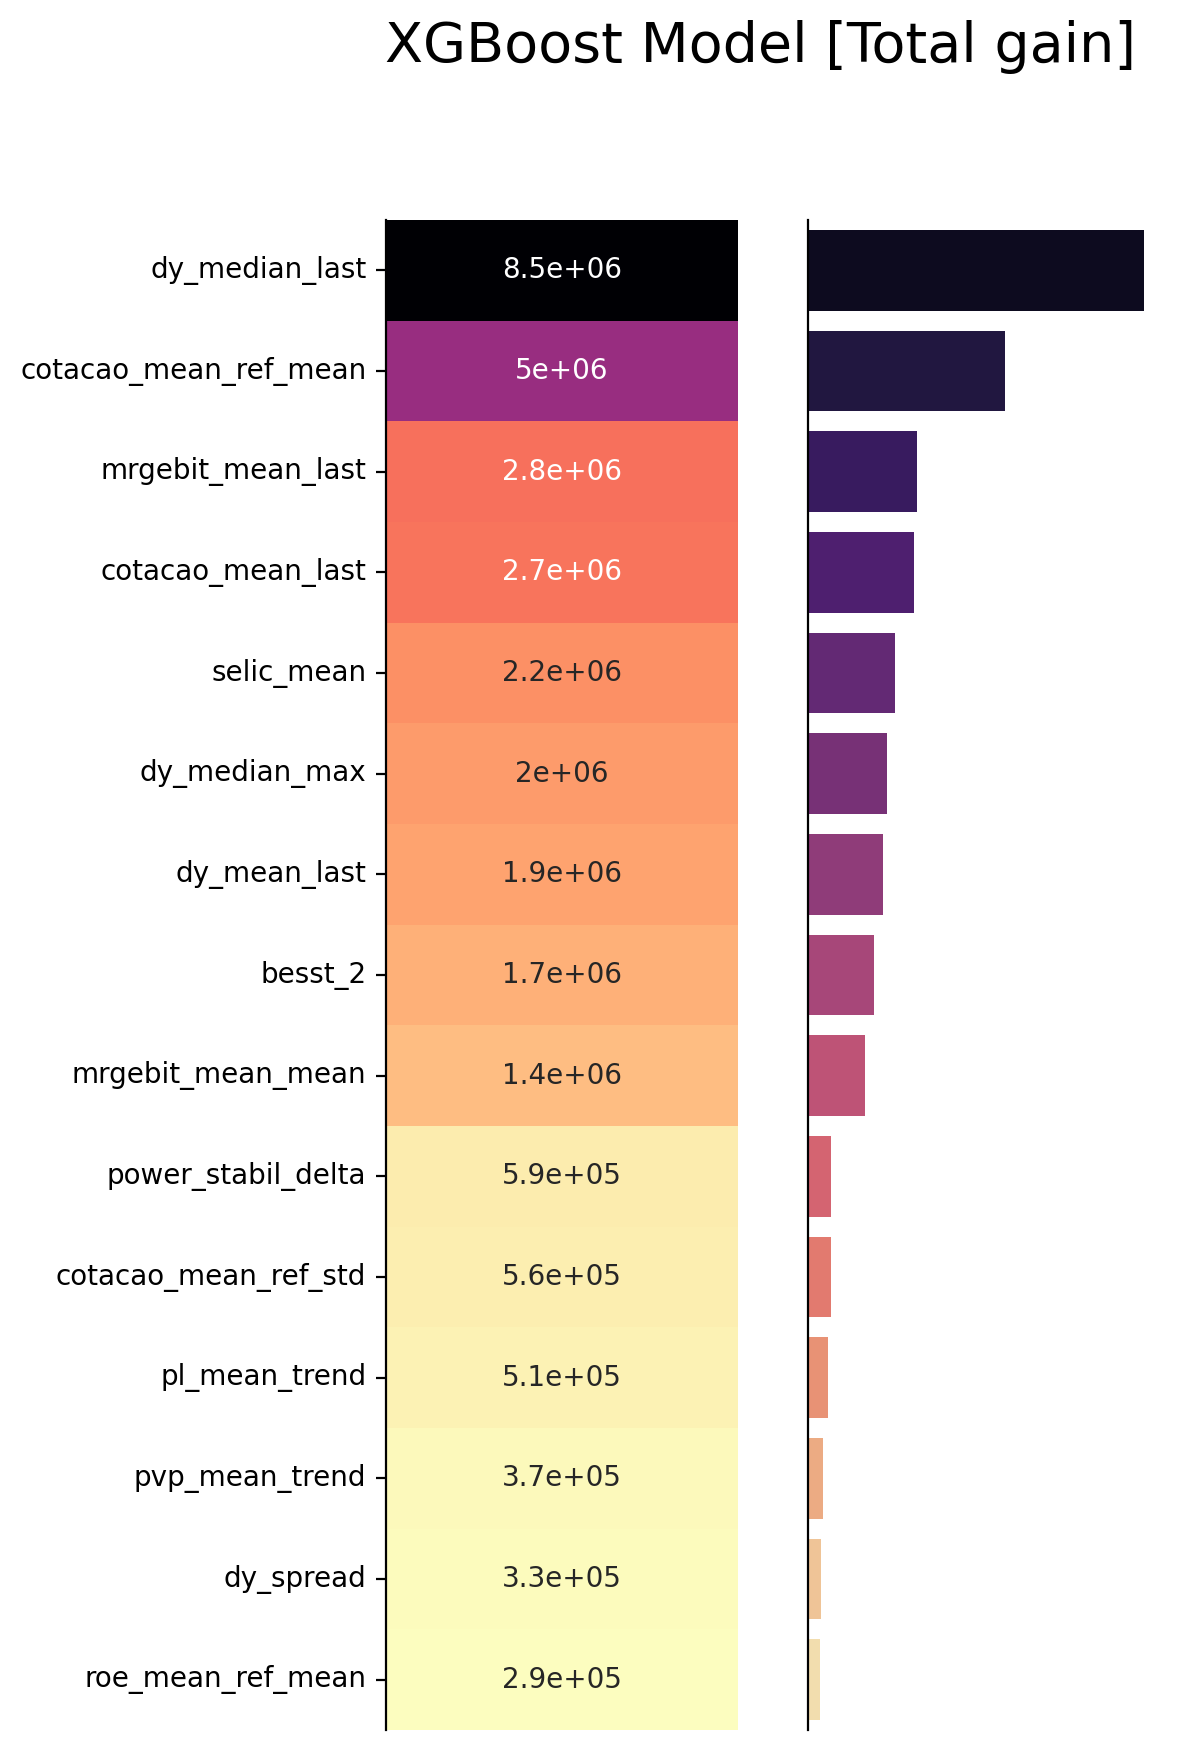

In [102]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
X = df.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
# X = df[training_features.index]
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor()

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('R2 score:', np.mean(scores['test_r2']))
print('Mean squared error:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

most_important = most_important_XGBoost_review

### Building a Machine Learning Pipeline 

In [103]:
def build_pipelines(regressors, transformers):
    pipelines = {}

    for transformer in transformers:
        for algorithm,regressor in regressors.items():
            pipeline = Pipeline([
                ('preprocessing', transformer),
                ('reg',regressor)
            ])
            pipelines[algorithm + '_' + str(transformer)] = pipeline

    return pipelines

In [104]:

def build_models(regressors,parameters_dict, transformers):
    pipelines = build_pipelines(regressors, transformers)

    cvs = {}
    
    for transformer in transformers:
        for algorithm,parameters in parameters_dict.items():
            # create grid search object
            cv = GridSearchCV(pipelines[algorithm + '_' + str(transformer)], cv=5, param_grid=parameters, scoring='r2')
            cvs[algorithm + '_' + str(transformer)] = cv

    print(cvs)
    
    return cvs

In [105]:
def display_and_store_results(X, y, y_test, y_pred, model, algorithm, sufix):

    # define the cross-validation method (e.g. KFold with 5 folds)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # define the evaluation metrics (r2 score and mean squared error)
    scoring = {'r2': make_scorer(r2_score), 
               'mse': make_scorer(mean_squared_error),
               'xve': make_scorer(explained_variance_score),
               'MAPE': make_scorer(mean_absolute_percentage_error)}
    # perform cross-validation and get the scores
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print(scores)
    scores['fit_time']  = scores['fit_time'].tolist() 
    scores['score_time']= scores['score_time'].tolist() 
    scores['test_r2']   = scores['test_r2'].tolist() 
    scores['test_mse']  = scores['test_mse'].tolist()
    scores['test_xve']  = scores['test_xve'].tolist()
    scores['test_MAPE'] = scores['test_MAPE'].tolist()

    print('CV R2 score:', np.mean(scores['test_r2']))
    print('CV MSE:', np.mean(scores['test_mse']))

    performance = {}

    test_score_r2 = r2_score(y_test, y_pred)
    test_score_mse = mean_squared_error(y_test, y_pred)
    test_score_xvs = explained_variance_score(y_test, y_pred)
    test_score_mape = mean_absolute_percentage_error(y_test, y_pred)

    print('test r2:', test_score_r2)
    print('test mse:', test_score_mse)
    print('test explained_variance_score:', test_score_xvs)
    print('test MAPE:', test_score_mape)

    performance['cv_scores'] = scores
    performance['test_scores'] = {}
    performance['test_scores']['r2'] = test_score_r2
    performance['test_scores']['mse'] = test_score_mse
    performance['test_scores']['explained_variance_score'] = test_score_xvs
    performance['test_scores']['MAPE'] = test_score_mape
    
    print('___________________________________')
        
    print("\nBest Parameters:", model.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':model.best_params_,
        'performance':performance,
        'features':X.columns.to_list()
    }

    patch = '../data/03_models/out/'
    filename = patch + f'{str(date.today())}_{algorithm}'

    # return performance
    if sufix != '':
        sufix_ = '_' + sufix
    else:
        sufix_ = sufix

    json.dump(performance, open(filename+f'_results{sufix_}.json', 'w'))   
    pickle.dump(model.best_estimator_, open(filename+f'{sufix_}.pkl', 'wb'))

    return test_score_r2



def train_models(df, params_path, label, regressors, transformers, cols_to_drop=None, cols_to_train=None, sufix=""):

    # separating the train and target features
    if cols_to_train == None:
        X = df.drop(cols_to_drop, axis=1)
    elif cols_to_train != None:
        print('here we go again')
        X = df[cols_to_train]
    else:
        raise

    y = df[label]

    with open(params_path) as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    models = build_models(regressors,parameters,transformers)

    for algorithm, model in models.items():
        # X, y = load_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

        print(algorithm)        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = display_and_store_results(X, y, y_test, y_pred, model, algorithm, sufix)
        print(algorithm, r2)

    return models


In [106]:
params_path = '../data/03_models/in/params.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer()]

models = train_models(df, params_path, label, regressors, transformers, cols_to_drop)

{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.1, 0.01],
                         'reg__n_estimators': [100, 500],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsampl

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([39.9511292 , 38.51947188, 41.97221923, 41.67678094, 37.96721363]), 'score_time': array([0.05301094, 0.04000902, 0.05401468, 0.05601406, 0.04801178]), 'test_r2': array([0.5860742 , 0.43102302, 0.38398112, 0.43263666, 0.49417431]), 'test_mse': array([ 91.47784953, 177.88424543, 324.57808864, 204.52769995,
        61.49914353]), 'test_xve': array([0.58608412, 0.43102885, 0.38407848, 0.43264468, 0.49451605]), 'test_MAPE': array([5.50745391e+14, 6.30902636e+14, 4.64267333e+14, 5.85913956e+14,
       6.97782457e+14])}
CV R2 score: 0.4655778608848153
CV MSE: 171.99340541721773
test r2: 0.7223303203254489
test mse: 85.87117092339192
test explained_variance_score: 0.7223305030434974
test MAPE: 477189786209967.4
___________________________________

Best Parameters: {'reg__learning_rate': 0.01, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.7223303203254489
XGBRegressor_Normalizer()
{'fi

In [40]:
def load_model(path, model_name):
    
    with open(path + model_name, 'rb') as file:
        model = pickle.load(file)

    loaded_model = None
    for step_name, step_model in model.named_steps.items():
        if isinstance(step_model, LGBMRegressor):
            loaded_model = step_model
            break
        elif isinstance(step_model, XGBRegressor):
            loaded_model = step_model
            break
        elif step_name == 'preprocessing':
            transformer = step_model

    return loaded_model, transformer

In [41]:
def make_predictions(path, model_name, results_file, X_to_pred):
    # model_name = '2023-08-04_LGBMRegressor_Normalizer()_feat_selection.pkl'
    with open(path + model_name, 'rb') as file:
        pipeline = pickle.load(file)

    with open(path + results_file, 'rb') as json_file:
        results = json.load(json_file)

    model, transformer = load_model(path, model_name)

    features = results['features']

    return pipeline.predict(X_to_pred[features]), pipeline, model, transformer, features

In [109]:
# separating the train and target features
X_to_pred = df_to_pred.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y_to_pred = df_to_pred['dy_label']

In [110]:
path = '../data/03_models/out/'
model_name = f'{date.today()}_LGBMRegressor_Normalizer().pkl'
results_file = f'{date.today()}_LGBMRegressor_Normalizer()_results.json'

df_to_pred['dy_pred_LN'], lgb_pipeline, lgb_model, lgb_model_transformer, lgb_model_features = make_predictions(path, model_name, results_file, X_to_pred)



model_name = f'{date.today()}_XGBRegressor_Normalizer().pkl'
model_name = f'{date.today()}_XGBRegressor_Normalizer().pkl'
results_file = f'{date.today()}_XGBRegressor_Normalizer()_results.json'

df_to_pred['dy_pred_XN'], xgb_pipeline, xgb_model, xgb_model_transformer, xgb_model_features = make_predictions(path, model_name, results_file, X_to_pred)


In [42]:
def get_feature_importances(model, model_class, features):
    if 'LGB' in model_class:
        feature_importances = model.booster_.feature_importance(importance_type='gain')
    elif 'XGB' in model_class:
        feature_importances = model.get_booster().get_score(importance_type='gain').values()
        
    # Create a dictionary to associate feature names with their importance scores
    feature_importance_dict = dict(zip(features, feature_importances))
    df_feature_importance = pd.DataFrame(feature_importance_dict, 
                                      index=['Total gain']).T.sort_values(by='Total gain', ascending=False)
    return df_feature_importance

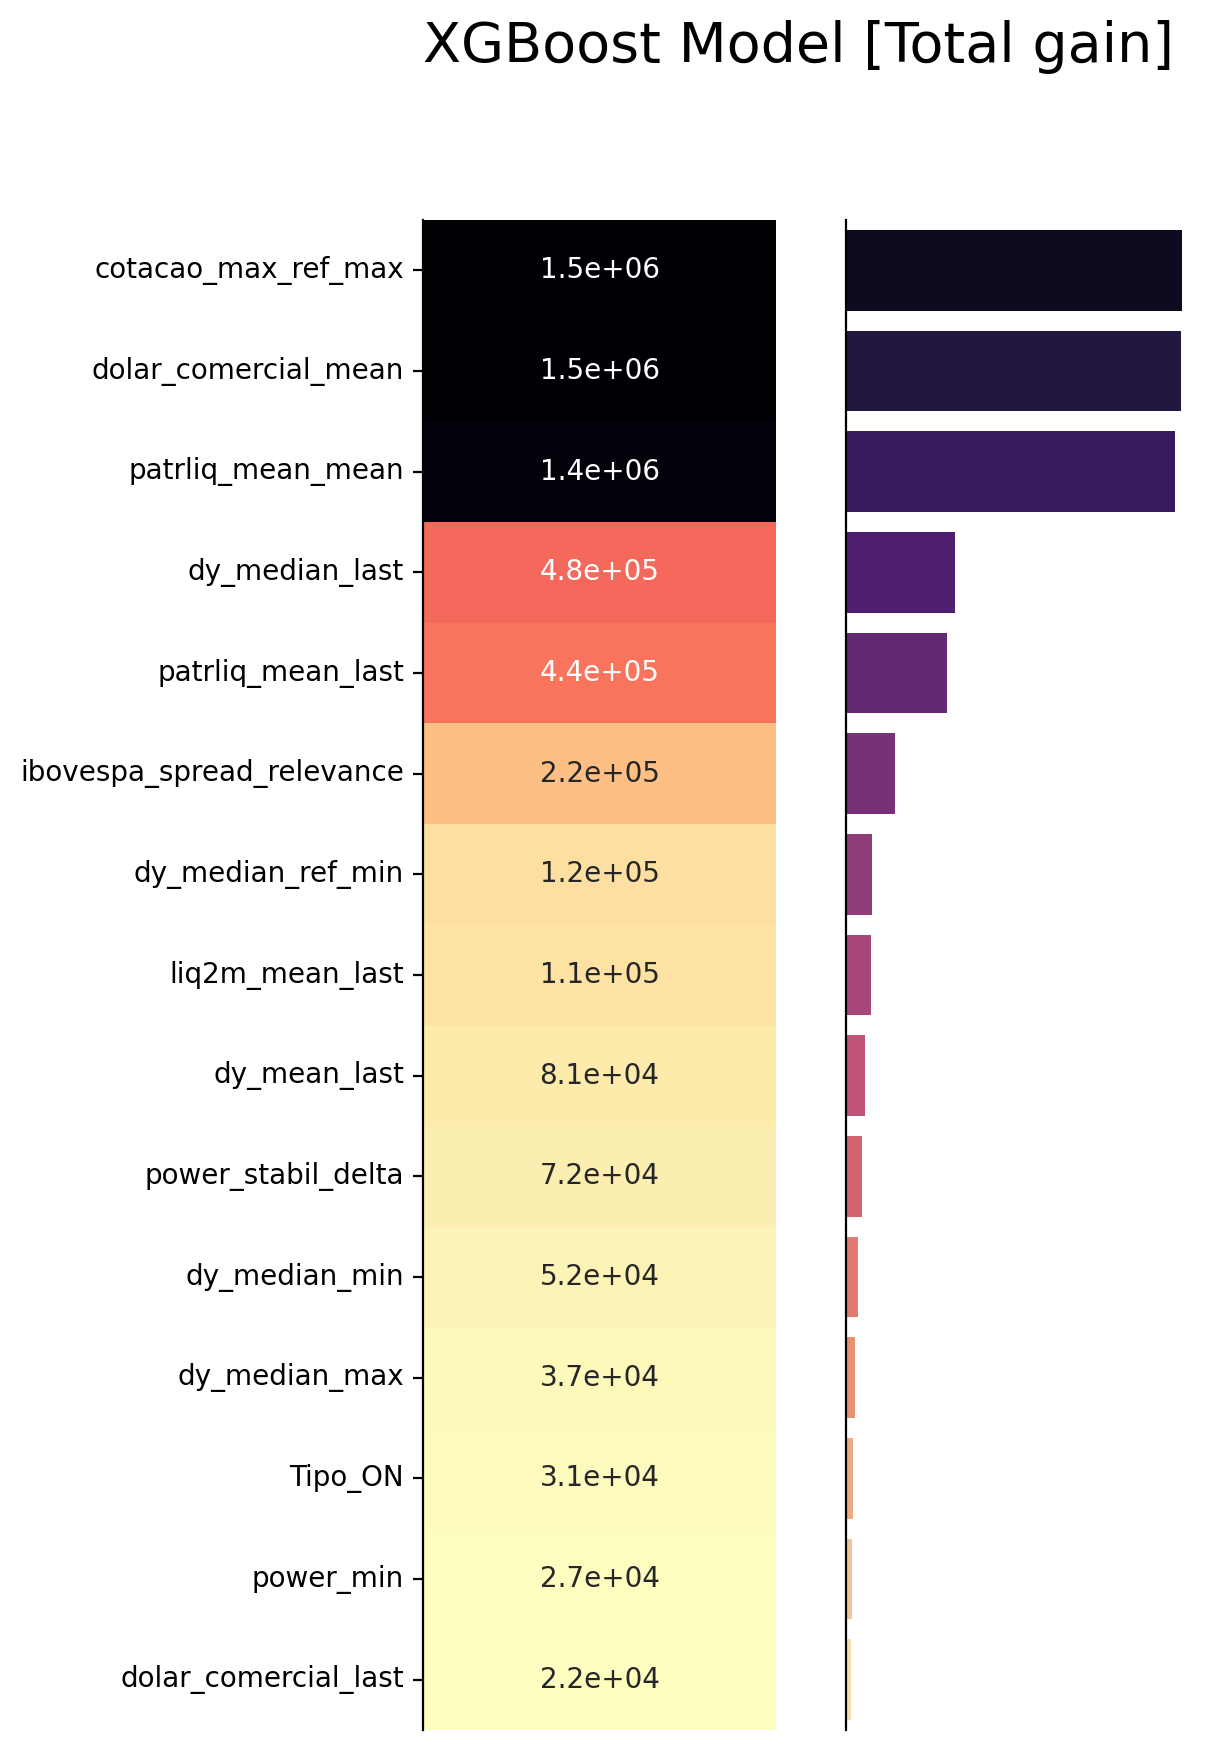

In [112]:
xgb_feature_importance = get_feature_importances(xgb_model, 'XGB', X.columns.to_list())
plot_importance(xgb_feature_importance, 'Total gain', 'XGBoost Model [Total gain]')

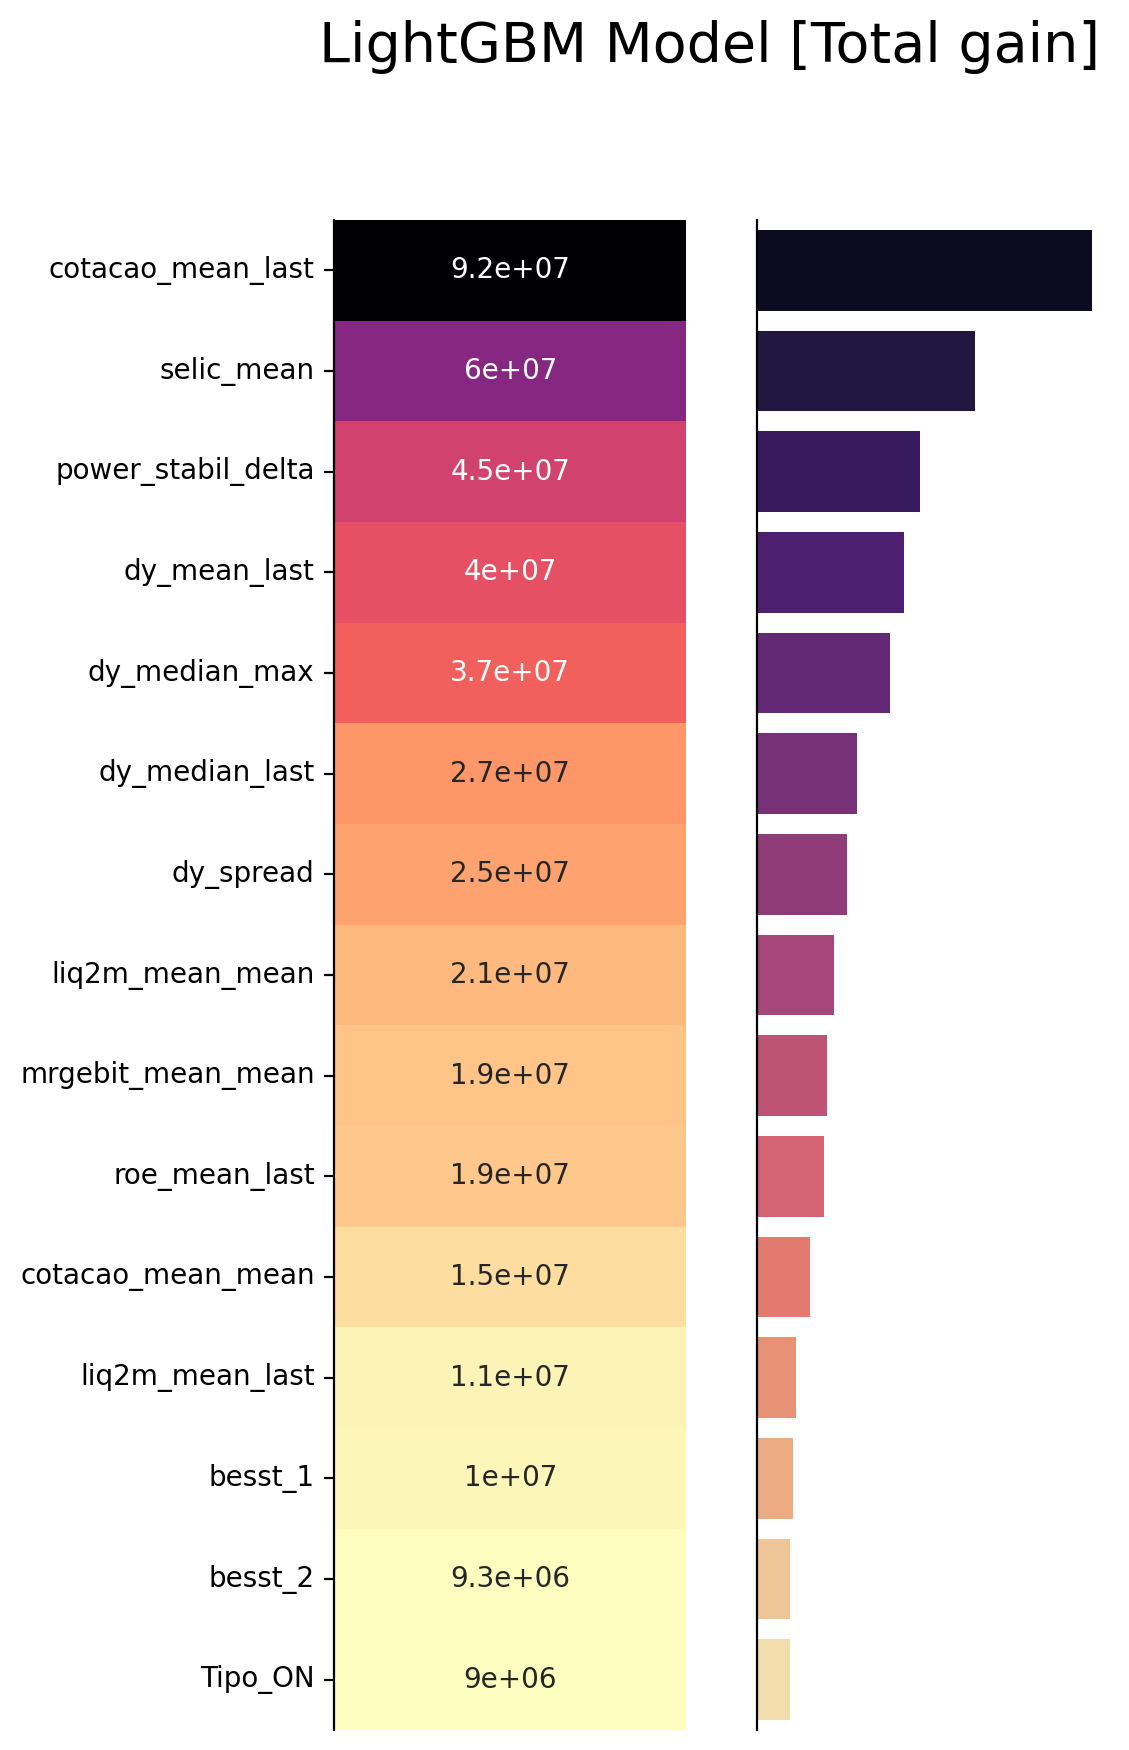

In [113]:
lgb_feature_importance = get_feature_importances(lgb_model, 'LGB', X.columns.to_list())
plot_importance(lgb_feature_importance, 'Total gain', 'LightGBM Model [Total gain]')

In [43]:
def calculate_shap_values(model, transformer, X_train, X_test, path, filename, plot=False):
    # If the LightGBM model is found, convert it to a LightGBM Booster object and prepare the explainer
    if model is not None:
        # Assuming you have your test data in 'X_test' (replace 'X_test' with your actual test data)
        explainer = shap.Explainer(model, transformer.transform(X_train))

        # Calculate SHAP values for the test data
        shap_values = explainer(transformer.transform(X_test), check_additivity=False)

        # Save SHAP values to a file using pickle
        with open(path + filename, 'wb') as file:
            pickle.dump(shap_values, file)

        # plot shap summary if desired
        if plot:
            shap.summary_plot(shap_values, X_test)
        
        # Return SHAP values
        return shap_values
    
    else:
        print("LightGBM model not found in the pipeline.")
    

 98%|===================| 22378/22875 [00:45<00:00]        

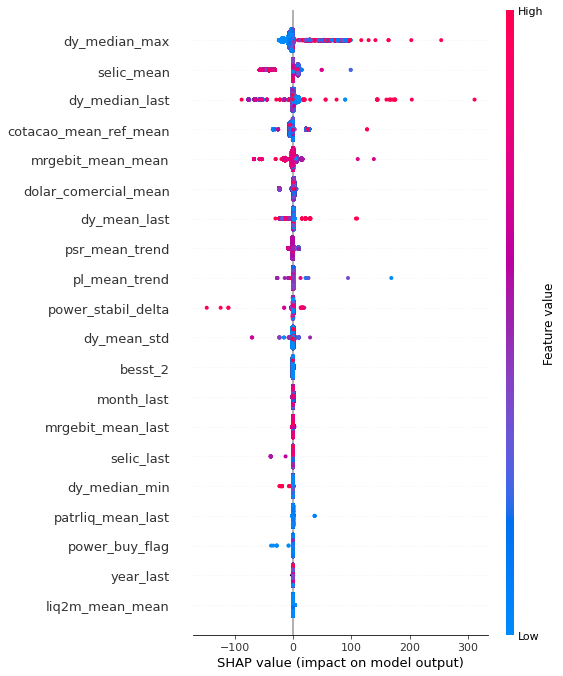

100%|===================| 22836/22875 [04:29<00:00]        

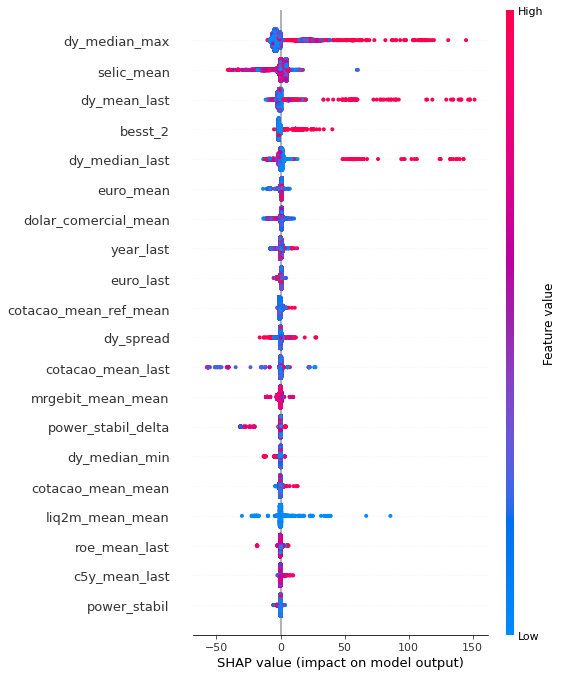

In [115]:
# X = df.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
X = df[xgb_model_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

path = '../data/03_models/out/'
file_name_shap = f'{date.today()}_XGBRegressor_Normalizer()_SHAP.pkl'

xgb_shap = calculate_shap_values(xgb_model, xgb_model_transformer, X_train, X_test, path, file_name_shap, plot=True)

# Save SHAP values to a file using pickle
with open(path + file_name_shap, 'wb') as file:
    pickle.dump(xgb_shap, file)




X = df[lgb_model_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

file_name_shap = f'{date.today()}_LGBMRegressor_Normalizer()_SHAP.pkl'

lgb_shap = calculate_shap_values(lgb_model, lgb_model_transformer, X_train, X_test, path, file_name_shap, plot=True)


# Save SHAP values to a file using pickle
with open(path + file_name_shap, 'wb') as file:
    pickle.dump(lgb_shap, file)

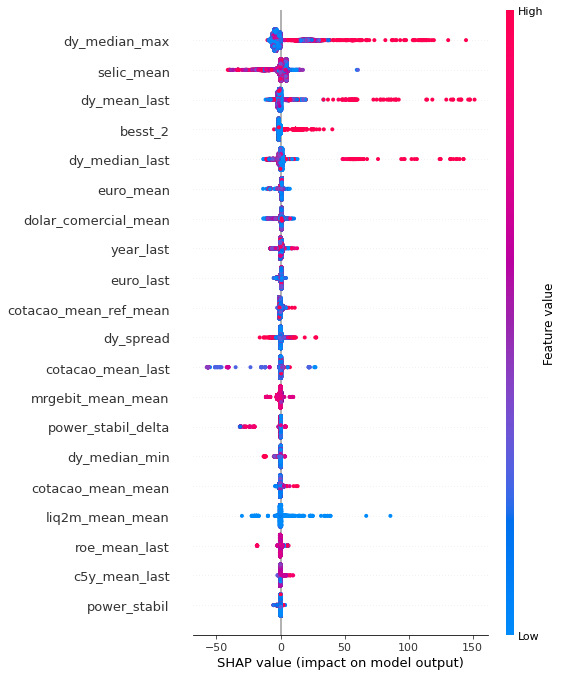

In [116]:
shap.summary_plot(lgb_shap, X_test)

In [117]:
d = dict(zip(xgb_model_features,np.abs(np.sum(xgb_shap.values, axis=0))))
df_xgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

d = dict(zip(lgb_model_features,np.abs(np.sum(lgb_shap.values, axis=0))))
df_lgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

In [118]:
n = 60

intersection_lgb_xgb = np.isin(df_lgb_shap.iloc[:n].index,df_xgb_shap.iloc[:n].index)
intersection_xgb_lgb = np.isin(df_xgb_shap.iloc[:n].index,df_lgb_shap.iloc[:n].index)
cols_to_train = df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index.to_list()

print('lgb in xgb ',np.mean(intersection_lgb_xgb))
print('xgb in lgb ',np.mean(intersection_xgb_lgb))
print('double check, cross intersection value', 
      np.isin(df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index,df_xgb_shap.iloc[:n].loc[intersection_xgb_lgb].index).mean())
print('\n\ncols to train:\n')
for col in  cols_to_train:
    print(col)

lgb in xgb  0.6
xgb in lgb  0.6
double check, cross intersection value 1.0


cols to train:

dy_median_max
besst_2
selic_mean
euro_mean
power_stabil_delta
dolar_comercial_mean
euro_last
dy_median_last
mrgebit_mean_mean
year_last
besst_1
dy_mean_last
cotacao_mean_ref_mean
power_buy_flag
pl_mean_trend
dy_spread
dy_median_min
pvp_mean_mean
cotacao_mean_mean
selic_last
cotacao_mean_last
dy_mean_std
psr_mean_last
liq2m_mean_ref_mean
pa_mean_trend
roic_mean_last
liq2m_mean_mean
pa_mean_last
pacl_mean_mean
roe_mean_mean


In [119]:
params_path = '../data/03_models/in/params_optimized.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer(),StandardScaler()]

models = train_models(df, params_path, label, regressors, transformers, cols_to_train=cols_to_train, sufix='feat_selection')

here we go again
{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.1],
                         'reg__max_depth': [3, 5, 7],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'XGBRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=N

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([34.87528753, 32.76680231, 32.49072123, 32.26566768, 32.43270755]), 'score_time': array([0.09102178, 0.06101513, 0.06601572, 0.05801368, 0.05101204]), 'test_r2': array([0.70565749, 0.73824895, 0.73436587, 0.78500855, 0.1035579 ]), 'test_mse': array([ 65.04987143,  81.8335176 , 139.96164605,  77.50184723,
       108.99094696]), 'test_xve': array([0.70565906, 0.73825182, 0.73438744, 0.78502634, 0.10371208]), 'test_MAPE': array([4.67763468e+14, 5.72054744e+14, 5.86219137e+14, 5.40342822e+14,
       8.72861466e+14])}
CV R2 score: 0.6133677528124479
CV MSE: 94.6675658530243
test r2: 0.6748197584272666
test mse: 100.56412402582282
test explained_variance_score: 0.6748224242651801
test MAPE: 550028815690374.94
___________________________________

Best Parameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.6748197584272666
XGBRegress

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([34.38315725, 34.95729303, 34.64321899, 37.1358614 , 37.15834808]), 'score_time': array([0.04101014, 0.05401301, 0.0410099 , 0.06696343, 0.07101727]), 'test_r2': array([0.7506943 , 0.65740356, 0.70714367, 0.73658693, 0.08270119]), 'test_mse': array([ 55.09670833, 107.10891764, 154.30492705,  94.95726378,
       111.52674094]), 'test_xve': array([0.75070676, 0.65740644, 0.70716215, 0.73658799, 0.08281453]), 'test_MAPE': array([7.17090944e+14, 7.55617863e+14, 7.06443775e+14, 7.96912007e+14,
       9.12800124e+14])}
CV R2 score: 0.5869059302488443
CV MSE: 104.59891154687077
test r2: 0.6728295429245337
test mse: 101.17961123281596
test explained_variance_score: 0.6728296483383762
test MAPE: 764533476159434.1
___________________________________

Best Parameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_StandardScaler() 0.6728295429245337
XGBRe

### Train model with the most important features from the LightGBM and XGBoost models

In [120]:
n = 60

intersection_lgb_xgb = np.isin(df_lgb_shap.iloc[:n].index,df_xgb_shap.iloc[:n].index)
intersection_xgb_lgb = np.isin(df_xgb_shap.iloc[:n].index,df_lgb_shap.iloc[:n].index)
cols_to_train_lgmb = df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index.to_list()

print('lgb in xgb ',np.mean(intersection_lgb_xgb))
print('xgb in lgb ',np.mean(intersection_xgb_lgb))
print('double check, cross intersection value', 
      np.isin(df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index,df_xgb_shap.iloc[:n].loc[intersection_xgb_lgb].index).mean())
print('\n\ncols to train:\n')
for col in  cols_to_train_lgmb:
    print(col)

lgb in xgb  0.6166666666666667
xgb in lgb  0.6166666666666667
double check, cross intersection value 1.0


cols to train:

dy_median_max
besst_2
selic_mean
euro_mean
power_stabil_delta
dolar_comercial_mean
euro_last
dy_median_last
mrgebit_mean_mean
year_last
besst_1
dy_mean_last
cotacao_mean_ref_mean
power_buy_flag
pl_mean_trend
dy_spread
dy_median_min
pvp_mean_mean
cotacao_mean_mean
selic_last
cotacao_mean_last
dy_mean_std
psr_mean_last
liq2m_mean_ref_mean
pa_mean_trend
roic_mean_last
cotacao_mean_trend
liq2m_mean_mean
pa_mean_last
pacl_mean_mean
roe_mean_mean
pebit_mean_ref_mean
pl_mean_ref_mean
power_stabil
month_last
ibovespa_last
patrliq_mean_last


In [121]:
params_path = '../data/03_models/in/params_optimized_lgbm.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer(),StandardScaler()]

models = train_models(df, params_path, label, regressors, transformers, 
                        cols_to_drop=None, 
                        cols_to_train=cols_to_train_lgmb, 
                        sufix='feat_selection_lgbm')

here we go again
{'LGBMRegressor_Normalizer()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', Normalizer()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.01, 0.5],
                         'reg__max_depth': [3, 5],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2'), 'LGBMRegressor_StandardScaler()': GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('reg', LGBMRegressor())]),
             param_grid={'reg__learning_rate': [0.01, 0.5],
                         'reg__max_depth': [3, 5],
                         'reg__n_estimators': [500, 1000],
                         'reg__reg_alpha': [0.1], 'reg__reg_lambda': [0.01]},
             scoring='r2')}
LGBMRegressor_Normalizer()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([47.54478407, 49.06615829, 48.09140468, 48.45749092, 48.79957223]), 'score_time': array([0.04200935, 0.05401206, 0.04901195, 0.05301332, 0.05201387]), 'test_r2': array([0.63014179, 0.57248663, 0.60915927, 0.59052185, 0.28733523]), 'test_mse': array([ 81.73888565, 133.65723978, 205.93254538, 147.61197747,
        86.64698794]), 'test_xve': array([0.6301507 , 0.57248809, 0.60918499, 0.59052332, 0.28755431]), 'test_MAPE': array([6.36221720e+14, 7.87031127e+14, 5.53217601e+14, 6.00805787e+14,
       9.03268786e+14])}
CV R2 score: 0.5379289555851924
CV MSE: 131.117527244858
test r2: 0.6500760410742175
test mse: 108.21628102256143
test explained_variance_score: 0.6501057467921499
test MAPE: 1710163861465679.2
___________________________________

Best Parameters: {'reg__learning_rate': 0.5, 'reg__max_depth': 3, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.6500760410742175
LGBMRegre

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([50.14989257, 45.9709022 , 46.74210191, 47.5217762 , 47.14268923]), 'score_time': array([0.05601358, 0.04300952, 0.04000998, 0.04300952, 0.04601097]), 'test_r2': array([0.68809746, 0.48011433, 0.49047516, 0.59413677, 0.44071909]), 'test_mse': array([ 68.93064755, 162.53640142, 268.46676872, 146.30884209,
        67.99831947]), 'test_xve': array([0.68814942, 0.48011433, 0.49054826, 0.59413696, 0.44091006]), 'test_MAPE': array([5.85519474e+14, 6.41995057e+14, 5.16310961e+14, 5.49249921e+14,
       8.36139252e+14])}
CV R2 score: 0.5387085607109358
CV MSE: 142.84819585151325
test r2: 0.6641278590573247
test mse: 103.87066408222402
test explained_variance_score: 0.6641505463678146
test MAPE: 385979400676198.1
___________________________________

Best Parameters: {'reg__learning_rate': 0.01, 'reg__max_depth': 5, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_StandardScaler() 0.6641278590573247


In [122]:
# Comparar a distribuição de dividendos das empresas indicadas com o besst1 e com o total em quartis
# Plotar a distribuição de dividendos de algum dos primeiros do ranking
# entender alguns outliers

## Analyse the prediction outcomes for each model
### Best models (Transformer + Algorithm + Feature Selection)

In [44]:
[col for col in df_to_pred.columns if 'power' in col]

['power_min',
 'power_buy_flag',
 'power_stabil_delta',
 'power_stabil',
 'power_valuation',
 'power_price',
 'power_margin']

In [45]:
# separating the train and target features
X_to_pred = df_to_pred.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y_to_pred = df_to_pred['dy_label']

100%|===================| 22831/22875 [08:49<00:01]        

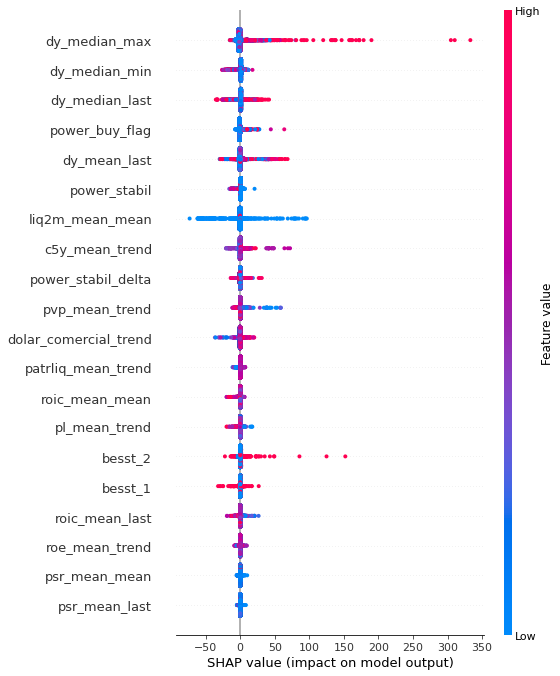

100%|===================| 22804/22875 [03:19<00:00]        

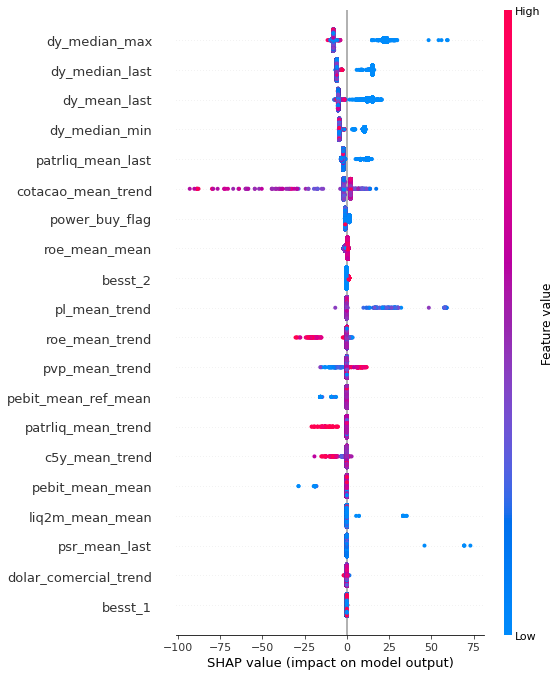

100%|===================| 22852/22875 [08:50<00:00]        

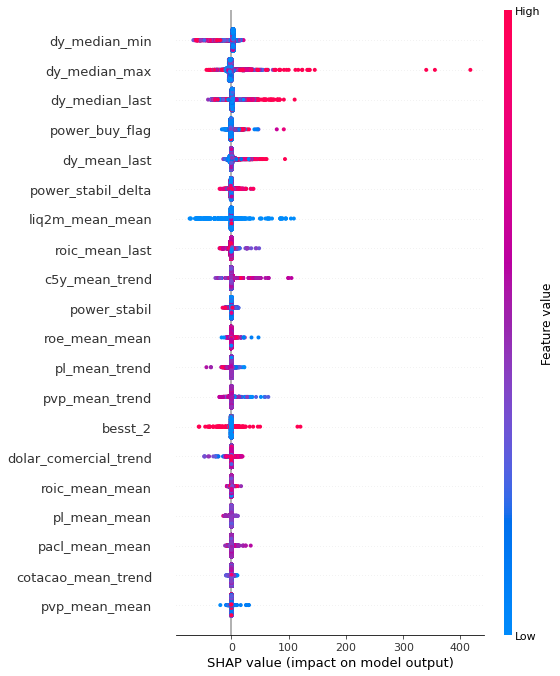

 99%|===================| 22743/22875 [02:33<00:00]        

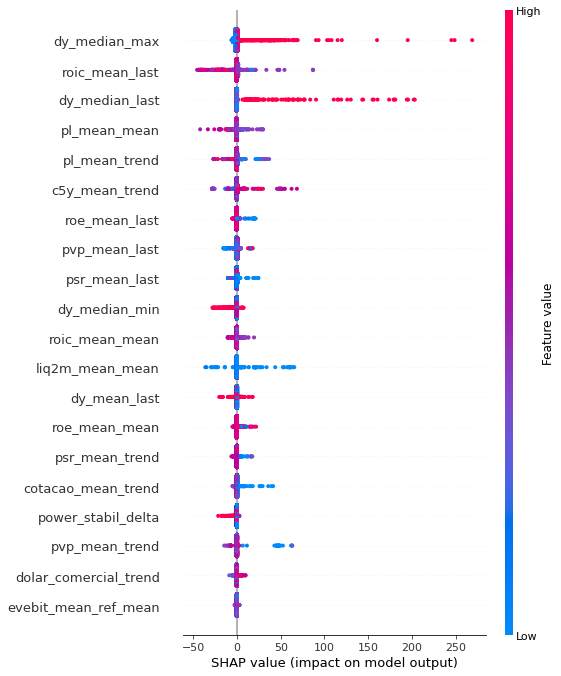

In [46]:
path = '../data/03_models/out/'

# '2023-08-07_LGBMRegressor_Normalizer()_feat_selection.pkl'

model_name = '2023-08-07_LGBMRegressor_Normalizer()_feat_selection.pkl'
results_file = '2023-08-07_LGBMRegressor_Normalizer()_results_feat_selection.json'
file_name_SHAP = '2023-08-07_LGBMRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

df_to_pred['dy_pred_N_FS'], N_FS_0807_pipeline, N_FS_0807_model, N_FS_0807_transformer, N_FS_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[N_FS_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

N_FS_0807_shap = calculate_shap_values(N_FS_0807_model, N_FS_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# '2023-08-07_LGBMRegressor_StandardScaler()_feat_selection.pkl' 

model_name = '2023-08-07_LGBMRegressor_StandardScaler()_feat_selection.pkl'
results_file = '2023-08-07_LGBMRegressor_StandardScaler()_results_feat_selection.json'
file_name_SHAP = '2023-08-07_LGBMRegressor_StandardScaler()_results_feat_selection_SHAP.pkl'

df_to_pred['dy_pred_S_FS'], S_FS_0807_pipeline, S_FS_0807_model, S_FS_0807_transformer, S_FS_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[S_FS_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

S_FS_0807_shap = calculate_shap_values(S_FS_0807_model, N_FS_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



path = '../data/03_models/out/'

# '2023-08-05_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'

model_name = '2023-08-07_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'
results_file = '2023-08-07_LGBMRegressor_Normalizer()_results_feat_selection_lgbm.json'
file_name_SHAP = '2023-08-07_LGBMRegressor_Normalizer()_results_feat_selection_lgbm_SHAP.pkl'

df_to_pred['dy_pred_N_FS_LGBM'], N_FS_LGBM_0807_pipeline, N_FS_LGBM_0807_model, N_FS_LGBM_0807_transformer, N_FS_LGBM_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[N_FS_LGBM_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

N_FS_LGBM_0807_shap = calculate_shap_values(N_FS_LGBM_0807_model, N_FS_LGBM_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# '2023-08-07_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl' 

model_name = '2023-08-07_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl'
results_file = '2023-08-07_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm.json'
file_name_SHAP = '2023-08-07_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm_SHAP.pkl'

df_to_pred['dy_pred_S_FS_LGBM'], S_FS_LGBM_0807_pipeline, S_FS_LGBM_0807_model, S_FS_LGBM_0807_transformer, S_FS_LGBM_0807_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[S_FS_LGBM_0807_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

S_FS_LGBM_0807_shap = calculate_shap_values(S_FS_LGBM_0807_model, S_FS_LGBM_0807_transformer, X_train, X_test, path, file_name_SHAP, plot=True)

100%|===================| 22794/22875 [01:27<00:00]        

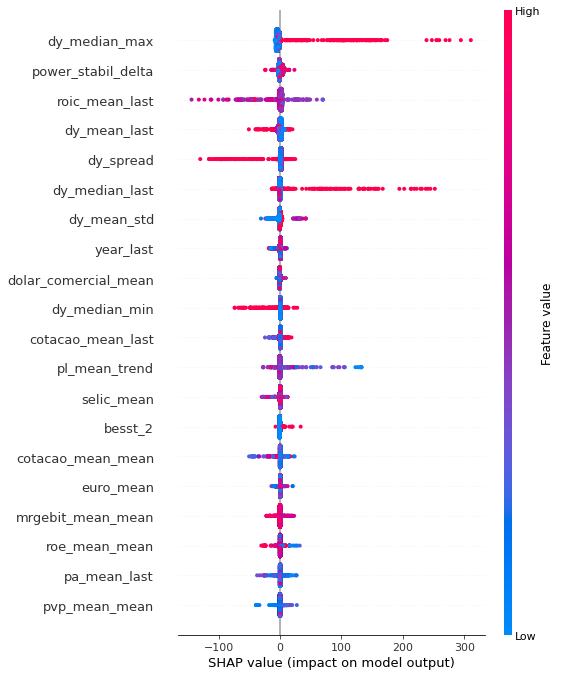

 99%|===================| 22692/22875 [01:27<00:00]        

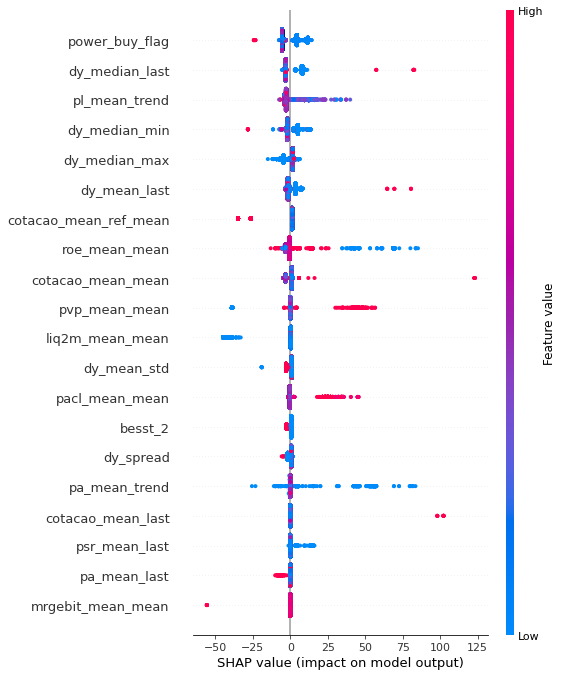

100%|===================| 22793/22875 [03:46<00:00]        

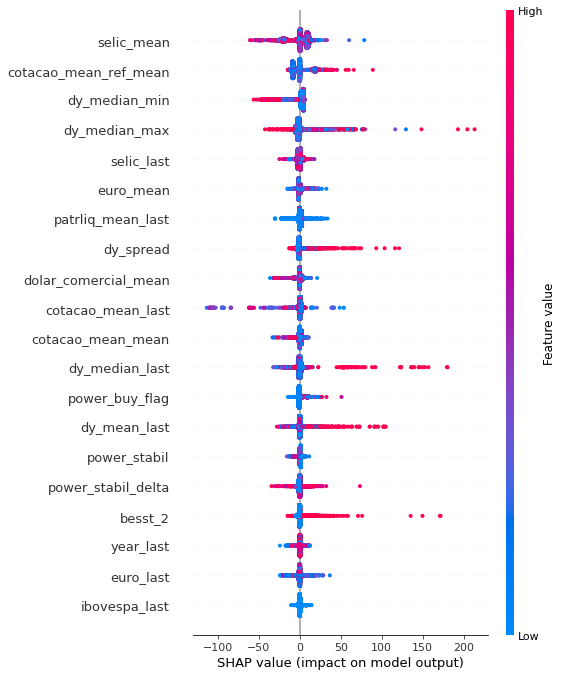

100%|===================| 22814/22875 [02:35<00:00]        

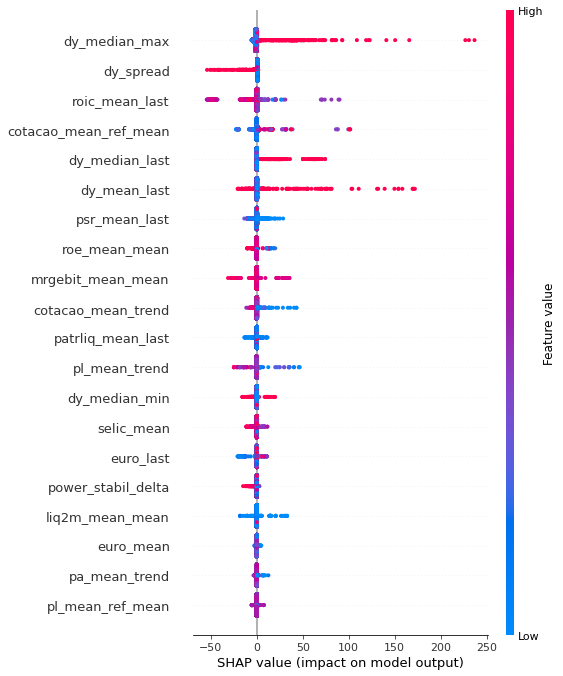

In [47]:
path = '../data/03_models/out/'

# '2023-08-08_LGBMRegressor_Normalizer()_feat_selection.pkl'

model_name = '2023-08-08_LGBMRegressor_Normalizer()_feat_selection.pkl'
results_file = '2023-08-08_LGBMRegressor_Normalizer()_results_feat_selection.json'
file_name_SHAP = '2023-08-08_LGBMRegressor_Normalizer()_results_feat_selection_SHAP.pkl'

df_to_pred['dy_pred_N_FS_0808'], N_FS_0808_pipeline, N_FS_0808_model, N_FS_0808_transformer, N_FS_0808_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[N_FS_0808_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

N_FS_0808_shap = calculate_shap_values(N_FS_0808_model, N_FS_0808_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# '2023-08-08_LGBMRegressor_StandardScaler()_feat_selection.pkl' 

model_name = '2023-08-08_LGBMRegressor_StandardScaler()_feat_selection.pkl'
results_file = '2023-08-08_LGBMRegressor_StandardScaler()_results_feat_selection.json'
file_name_SHAP = '2023-08-08_LGBMRegressor_StandardScaler()_results_feat_selection_SHAP.pkl'

df_to_pred['dy_pred_S_FS_0808'], S_FS_0808_pipeline, S_FS_0808_model, S_FS_0808_transformer, S_FS_0808_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[S_FS_0808_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

S_FS_0808_shap = calculate_shap_values(S_FS_0808_model, N_FS_0808_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



path = '../data/03_models/out/'

# '2023-08-05_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'

model_name = '2023-08-08_LGBMRegressor_Normalizer()_feat_selection_lgbm.pkl'
results_file = '2023-08-08_LGBMRegressor_Normalizer()_results_feat_selection_lgbm.json'
file_name_SHAP = '2023-08-08_LGBMRegressor_Normalizer()_results_feat_selection_lgbm_SHAP.pkl'

df_to_pred['dy_pred_N_FS_LGBM_0808'], N_FS_LGBM_0808_pipeline, N_FS_LGBM_0808_model, N_FS_LGBM_0808_transformer, N_FS_LGBM_0808_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[N_FS_LGBM_0808_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

N_FS_LGBM_0808_shap = calculate_shap_values(N_FS_LGBM_0808_model, N_FS_LGBM_0808_transformer, X_train, X_test, path, file_name_SHAP, plot=True)



# '2023-08-08_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl' 

model_name = '2023-08-08_LGBMRegressor_StandardScaler()_feat_selection_lgbm.pkl'
results_file = '2023-08-08_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm.json'
file_name_SHAP = '2023-08-08_LGBMRegressor_StandardScaler()_results_feat_selection_lgbm_SHAP.pkl'

df_to_pred['dy_pred_S_FS_LGBM_0808'], S_FS_LGBM_0808_pipeline, S_FS_LGBM_0808_model, S_FS_LGBM_0808_transformer, S_FS_LGBM_0808_features = make_predictions(path, model_name, results_file, X_to_pred)

X = df[S_FS_LGBM_0808_features]
y = df['dy_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

S_FS_LGBM_0808_shap = calculate_shap_values(S_FS_LGBM_0808_model, S_FS_LGBM_0808_transformer, X_train, X_test, path, file_name_SHAP, plot=True)


In [48]:
df_to_pred.head()

Empresa  Papel year_month  dy_label  dy_mean_last  \
178              ABC Brasil PN N2  ABCB4  2022.04.0  0.067515      0.073543   
357                  ABYARA ON NM  ABYA3  2022.04.0  0.004198      0.007711   
536  ARCELORMITTAL INOX BRASIL ON  ACES3  2022.04.0  0.000000      0.000000   
715  ARCELORMITTAL INOX BRASIL PN  ACES4  2022.04.0  0.000000      0.000000   
894                   AES ELPA ON  AELP3  2022.04.0  0.000000      0.000000   

     dy_median_last  dy_median_max  dy_spread  dy_median_min  power_min  \
178        0.073543       0.080751   0.022700       0.074114   0.237718   
357        0.007710       0.012087   0.012206       0.008051   0.010528   
536        0.000000       0.000000   0.000000       0.000000   0.000000   
715        0.000000       0.000000   0.000000       0.000000   0.000000   
894        0.000000       0.000000   0.000000       0.000000   0.000000   

     dy_median_ref_min  power_buy_flag  power_stabil_delta  besst_1  Tipo_PN  \
178           3.207460        0.039076            3.099654      1.0        1   
357           1.307598       -0.013335            3.281662      0.0        0   
536           0.000000        0.000000            0.000000      0.0        0   
715           0.000000        0.000000            0.000000      0.0        1   
894           0.000000        0.000000            0.000000      1.0        0   

     Tipo_ON  Lucro_Liquido_12m_category  dy_mean_std  encoded_sectors  \
178        0                         8.0     0.002141               26   
357        1                         2.0     0.001230               31   
536        1                         8.0   312.472845               32   
715        0                         8.0   312.472845               32   
894        1                         3.0   312.472845               33   

     euro_mean  euro_last  dolar_comercial_mean  dolar_comercial_last  \
178   4.469975     5.1852              4.318067                4.9191   
357   4.469975     5.1852              4.318067                4.9191   
536   4.469975     5.1852              4.318067                4.9191   
715   4.469975     5.1852              4.318067                4.9191   
894   4.469975     5.1852              4.318067                4.9191   

     power_stabil  year_last  cotacao_mean_mean  dolar_comercial_trend  \
178     34.613738     2022.0          17.804887              13.919038   
357      6.547186     2022.0           4.966658              13.919038   
536      0.000000     2022.0          95.270000              13.919038   
715      0.000000     2022.0          94.730000              13.919038   
894      0.000000     2022.0           1.865218              13.919038   

     patrliq_mean_mean  patrliq_mean_last  selic_trend  cotacao_mean_ref_mean  \
178       5.017177e+09       4.730839e+09     4.791472               1.866292   
357       2.920600e+08       2.920600e+08     4.791472               0.949510   
536       3.105800e+09       3.105800e+09     4.791472               6.527100   
715       3.105800e+09       3.105800e+09     4.791472               6.490104   
894      -9.040000e+05      -9.040000e+05     4.791472               0.084747   

     liq2m_mean_mean  besst_2  liq2m_mean_last  liqc_mean_mean  \
178     1.571000e+07      0.0     1.395931e+07        0.000000   
357     1.784236e-04      0.0     7.307644e-05        1.835512   
536    -3.846258e-03      1.0    -1.575507e-03        2.050000   
715    -3.845597e-03      1.0    -1.575236e-03        2.050000   
894    -3.181354e-05      0.0     3.087034e-04       -0.711854   

     cotacao_max_ref_max  selic_last  ibovespa_spread_relevance  \
178             1.984762    0.043739                        1.0   
357             1.000062    0.043739                        1.0   
536             7.440709    0.043739                        1.0   
715             7.398534    0.043739                        1.0   
894             0.093069    0.043739                        1.0   

   

## Recommend 20 best Stocks

In [88]:
df_to_pred['Papel_root'] = df_to_pred['Papel'].str[:4]

df_recommend = df_to_pred[['Empresa','Papel','Papel_root','besst_1','besst_2','dy_label','pl_mean_last','cotacao_mean_last',
                            'dy_pred_N_FS',
                            'dy_pred_S_FS',
                            'dy_pred_N_FS_LGBM',
                            'dy_pred_S_FS_LGBM',
                            'dy_pred_N_FS_0808',
                            'dy_pred_S_FS_0808',
                            'dy_pred_N_FS_LGBM_0808',
                            'dy_pred_S_FS_LGBM_0808']]\
                    .sort_values(by='dy_pred_N_FS', ascending=False)\
                    .drop_duplicates(subset=['Papel_root'], keep='first')

In [100]:
def get_dy_metrics(data, sort_col, filter_col,value_filter):

    data = data.sort_values(by=sort_col, ascending=False)
    
    d = {}
    d['top5'] = {
                        'dy_mean'     : data['dy_label'].iloc[:5].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:5].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:5].mean()
                    }

    d['top10'] = {
                        'dy_mean'     : data['dy_label'].iloc[:10].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:10].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:10].mean()
                    }

    d['top20'] = {
                        'dy_mean'     : data['dy_label'].iloc[:20].mean(),
                        'pl_mean_last'     : data['pl_mean_last'].iloc[:20].mean(),
                        'cotacao_mean_last': data['cotacao_mean_last'].iloc[:20].mean()
                    }

    d[f'top5_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:5].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:5].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:5].mean()
                    }

    d[f'top10_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:10].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:10].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:10].mean()
                    }

    d[f'top20_{filter_col}'] = {
                        'dy_mean'     : data[data[filter_col]==value_filter]['dy_label'].iloc[:20].mean(),
                        'pl_mean_last'     : data[data[filter_col]==value_filter]['pl_mean_last'].iloc[:20].mean(),
                        'cotacao_mean_last': data[data[filter_col]==value_filter]['cotacao_mean_last'].iloc[:20].mean()
                    }

    return pd.DataFrame(d)

In [85]:
df_recommend.sort_values(by='dy_pred_N_FS_LGBM', ascending=False).iloc[:10]

Empresa  Papel Papel_root  besst_1  dy_label  \
45199       LOPES BRASIL ON NM  LPSB3       LPSB      0.0  0.002627   
32848                 FIBAM PN  FBMC4       FBMC      0.0  0.000000   
26941  METALURGICA DUQUE SA PN  DUQE4       DUQE      0.0  0.001178   
37502       Generalshopp ON NM  GSHP3       GSHP      0.0  1.365604   
81671              VALID ON NM  VLID3       VLID      0.0  0.000000   
14319               CAL S/A PN  CALI4       CALI      0.0  0.031231   
90696        PLANOEPLANO ON NM  PLPL3       PLPL      0.0  0.022731   
79943      BR PROPERTIES ON NM  BRPR3       BRPR      0.0  0.523386   
21571                   CR2 ON  CRDE3       CRDE      0.0  0.076265   
88691          OMEGA GER ON NM  OMGE3       OMGE      1.0  0.000410   

       pl_mean_last  cotacao_mean_last  dy_pred_N_FS  dy_pred_S_FS  \
45199      4.931297           3.512931      5.921308     -0.066429   
32848     -0.096410           1.851865     -0.112946      0.064894   
26941     -0.162569           2.806783      0.742871      0.051943   
37502     -1.676945          29.694587     12.081279     93.747081   
81671     28.765253          10.472622      0.540552     24.334254   
14319    887.170765          49.980898      2.343648     -0.287904   
90696      4.041423           3.119210      0.190987      0.504804   
79943  -1675.490668          14.710164      4.139987     68.066860   
21571     -3.037851          20.553382      4.713342     -0.010030   
88691 -19985.560381          28.903974     -1.114974      0.033902   

       dy_pred_N_FS_LGBM  dy_pred_S_FS_LGBM  dy_pred_N_FS_0808  \
45199          50.365672           0.020112           0.030859   
32848          32.393646           0.035421          -0.180805   
26941          12.448588           0.035421          -0.039048   
37502           9.582041          76.777322         -20.101926   
81671           7.762403          45.394151           0.009705   
14319           6.308593           0.032369           0.044738   
90696           6.082270           0.124805           0.054811   
79943           5.637059          53.062113           0.016645   
21571           5.255678           0.122114          -0.167080   
88691           4.332619           0.020919           0.051409   

       dy_pred_S_FS_0808  dy_pred_N_FS_LGBM_0808  dy_pred_S_FS_LGBM_0808  \
45199           0.293801               -1.893418                0.052177   
32848           0.021888                2.054059                0.038296   
26941           0.018269               -1.304174                0.038296   
37502         -16.611996              -13.029641                1.751729   
81671          79.457311              -14.532633               12.669690   
14319          -5.645919              -12.104729                0.025862   
90696           0.217121               -1.077273                0.136944   
79943          -3.427355              -15.212033                1.360879   
21571           0.095835               -1.050863                0.115997   
88691           0.236368               -2.255390                0.009764   

           score  
45199   3.220223  
32848   2.435426  
26941   1.427985  
37502   9.880197  
81671  11.770435  
14319   1.168668  
90696   1.216359  
79943   8.234725  
21571   1.416937  
88691   0.754128

In [86]:
[col for col in df_recommend.columns if 'cotacao' in col]

['cotacao_mean_last']

In [89]:
dict_results = {'dy_pred_N_FS_0808'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS_0808', 'besst_1', 1),
                'dy_pred_S_FS_0808'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS_0808', 'besst_1', 1),
                'dy_pred_N_FS_LGBM_0808' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM_0808', 'besst_1', 1),
                'dy_pred_S_FS_LGBM_0808' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM_0808', 'besst_1', 1),
                'dy_pred_N_FS'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS', 'besst_1', 1),
                'dy_pred_S_FS'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS', 'besst_1', 1),
                'dy_pred_N_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM', 'besst_1', 1),
                'dy_pred_S_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM', 'besst_1', 1)}

dict_results2= {'dy_pred_N_FS_0808'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS_0808', 'besst_2', 1),
                'dy_pred_S_FS_0808'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS_0808', 'besst_2', 1),
                'dy_pred_N_FS_LGBM_0808' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM_0808', 'besst_2', 1),
                'dy_pred_S_FS_LGBM_0808' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM_0808', 'besst_2', 1),
                'dy_pred_N_FS'      :get_dy_metrics(df_recommend, 'dy_pred_N_FS', 'besst_2', 1),
                'dy_pred_S_FS'      :get_dy_metrics(df_recommend, 'dy_pred_S_FS', 'besst_2', 1),
                'dy_pred_N_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_N_FS_LGBM', 'besst_2', 1),
                'dy_pred_S_FS_LGBM' :get_dy_metrics(df_recommend, 'dy_pred_S_FS_LGBM', 'besst_2', 1)}

                

In [91]:
df_recommend['score'] = np.log(1 + df_recommend['dy_pred_N_FS_0808'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N_FS_0808']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_S_FS_0808'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_S_FS_0808']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_N_FS_LGBM_0808'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N_FS_LGBM_0808']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_S_FS_LGBM_0808'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_S_FS_LGBM_0808']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_N_FS'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N_FS']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_S_FS'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_S_FS']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_N_FS_LGBM'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_N_FS_LGBM']['top10'].loc['dy_mean']) + \
                        np.log(1 + df_recommend['dy_pred_S_FS_LGBM'].apply(lambda x: x if x>= 0 else 0)*dict_results['dy_pred_S_FS_LGBM']['top10'].loc['dy_mean'])

In [105]:
dict_results['score'] = get_dy_metrics(df_recommend, 'score', 'besst_1', 1)
dict_results2['score'] = get_dy_metrics(df_recommend, 'score', 'besst_2', 1)

In [208]:
top_results = {}
for key in dict_results.keys():
    top_results[key] = df_recommend.sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

In [209]:
for key in dict_results.keys():
    top_results[f'{key}_besst_1'] = df_recommend[df_recommend['besst_1']==1].sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

for key in dict_results.keys():
    top_results[f'{key}_besst_2'] = df_recommend[df_recommend['besst_2']==1].sort_values(by=key, ascending=False)['dy_label'].iloc[:50].to_list()

In [210]:
df_top_results = pd.DataFrame(top_results)

In [211]:
df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_mean_top20', var_name='Model').groupby('Model').mean()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_mean_top10', var_name='Model').groupby('Model').mean()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_mean_top5', var_name='Model').groupby('Model').mean()               

In [248]:
df_top_results_melt_full = pd.concat([df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_std_top20', var_name='Model').groupby('Model').std()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_std_top10', var_name='Model').groupby('Model').std()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_std_top5', var_name='Model').groupby('Model').std()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                                value_name='DY_median_top20', var_name='Model').groupby('Model').median()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[:10][df_top_results.columns], 
                                value_name='DY_median_top10', var_name='Model').groupby('Model').median()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[:5][df_top_results.columns], 
                                value_name='DY_median_top5', var_name='Model').groupby('Model').median()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

In [250]:
df_top_results_melt_full.head()

DY_mean_top5  DY_mean_top10  DY_mean_top20  \
Model                                                                   
dy_pred_N_FS                   0.295514       0.157455       0.218515   
dy_pred_N_FS_0808              0.402630       0.208528       0.137062   
dy_pred_N_FS_0808_besst_1      0.040342       0.059950       0.058743   
dy_pred_N_FS_0808_besst_2      0.016501       0.030110       0.033248   
dy_pred_N_FS_LGBM              0.273882       0.202343       0.110336   

                           DY_std_top5  DY_std_top10  DY_std_top20  
Model                                                               
dy_pred_N_FS                  0.598826      0.425462      0.435407  
dy_pred_N_FS_0808             0.632214      0.468933      0.334864  
dy_pred_N_FS_0808_besst_1     0.055284      0.078101      0.056641  
dy_pred_N_FS_0808_besst_2     0.018829      0.025062      0.027846  
dy_pred_N_FS_LGBM             0.610292      0.439279      0.317136

### Analysis for the overall stocks

In [282]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_' not in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  \
Model                                                                
dy_pred_N_FS                0.295514       0.157455       0.218515   
dy_pred_N_FS_0808           0.402630       0.208528       0.137062   
dy_pred_N_FS_LGBM           0.273882       0.202343       0.110336   
dy_pred_N_FS_LGBM_0808      0.376878       0.268873       0.144702   
dy_pred_S_FS                0.682296       0.398364       0.237452   
dy_pred_S_FS_0808           0.363215       0.196724       0.113393   
dy_pred_S_FS_LGBM           0.733477       0.430554       0.242099   
dy_pred_S_FS_LGBM_0808      0.577619       0.377314       0.211706   
score                       0.725092       0.443091       0.238677   

                        DY_std_top5  DY_std_top10  DY_std_top20  \
Model                                                             
dy_pred_N_FS               0.598826      0.425462      0.435407   
dy_pred_N_FS_0808          0.632214      0.468933      0.334864   
dy_pred_N_FS_LGBM          0.610292      0.439279      0.317136   
dy_pred_N_FS_LGBM_0808     0.634787      0.450801      0.336319   
dy_pred_S_FS               0.717898      0.568753      0.431829   
dy_pred_S_FS_0808          0.642245      0.463614      0.332186   
dy_pred_S_FS_LGBM          0.666377      0.559023      0.431540   
dy_pred_S_FS_LGBM_0808     0.782144      0.580214      0.435419   
score                      0.673756      0.549621      0.433284   

                        DY_sharpe_ratio_top5  DY_sharpe_ratio_top10  \
Model                                                                 
dy_pred_N_FS                        0.493488               0.370080   
dy_pred_N_FS_0808                   0.636857               0.444686   
dy_pred_N_FS_LGBM                   0.448772               0.460625   
dy_pred_N_FS_LGBM_0808              0.593707               0.596434   
dy_pred_S_FS                        0.950409               0.700416   
dy_pred_S_FS_0808                   0.565540               0.424328   
dy_pred_S_FS_LGBM                   1.100693               0.770190   
dy_pred_S_FS_LGBM_0808              0.738507               0.650301   
score                               1.076194               0.806175   

                        DY_sharpe_ratio_top20  
Model                                          
dy_pred_N_FS                         0.501864  
dy_pred_N_FS_0808                    0.409307  
dy_pred_N_FS_LGBM                    0.347913  
dy_pred_N_FS_LGBM_0808               0.430252  
dy_pred_S_FS                         0.549874  
dy_pred_S_FS_0808                    0.341354  
dy_pred_S_FS_LGBM                    0.561012  
dy_pred_S_FS_LGBM_0808               0.486212  
score                                0.550857

In [283]:
def plot_results(data, y, title, palette):
    plt.figure(figsize=(20,20), dpi=400)
    ax = sns.barplot(x=data.sort_values(y).index,
                    y=y, palette=palette, data=data.sort_values(y))
    # ax = sns.barplot(x=df_grupos_de_despesas.index[:-1],
    #                  y='Valor', palette='viridis', data=df_grupos_de_despesas[:-1])
    plt.xlabel('Model Output',fontsize=24)
    plt.ylabel('DY [-]', fontsize=20)
    plt.title(title, fontsize=24)
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize=20)

    for p in ax.patches:
        ax.annotate('{:,.3f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.005), fontsize=20,rotation=0)
    sns.despine()
    plt.tight_layout()


def create_syled_sheet(data, filter_word_in, sort_col, cmap):
    return data.sort_values(sort_col, ascending=False)[[col for col in data.columns if filter_word_in in col]]\
        .style.background_gradient(cmap=cmap,axis=0)


In [284]:
plot_results(df_top_results_melt, 'DY_mean_top5', 'DY Mean Value - Top 5','rocket')

In [285]:
plot_results(df_top_results_melt, 'DY_std_top5', 'DY Std Value - Top 5','viridis')

In [286]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Std Value - Top 10','rocket')

In [287]:
plot_results(df_top_results_melt, 'DY_std_top10', 'DY Std Value - Top 10','viridis')

In [288]:
plot_results(df_top_results_melt, 'DY_mean_top20', 'DY Mean Value - Top 20','rocket')

In [289]:
plot_results(df_top_results_melt, 'DY_std_top20', 'DY Std Value - Top 20','viridis')

In [290]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [291]:
create_syled_sheet(df_top_results_melt, 'std', 'DY_mean_top10', 'vlag')

In [294]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

In [ ]:
df_comparison_styled = df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]]\
    .sort_values('DY_mean_top10', ascending=False).style.background_gradient(cmap='rocket',axis=0)
df_comparison_styled

### Analysis for the BESST_1 Stocks (Sectors: A, B C ...)

In [298]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_1' in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  \
Model                                                                        
dy_pred_N_FS_0808_besst_1           0.040342       0.059950       0.058743   
dy_pred_N_FS_LGBM_0808_besst_1      0.143990       0.075277       0.045864   
dy_pred_N_FS_LGBM_besst_1           0.015702       0.010179       0.025958   
dy_pred_N_FS_besst_1                0.093763       0.095880       0.062997   
dy_pred_S_FS_0808_besst_1           0.082999       0.052291       0.053773   
dy_pred_S_FS_LGBM_0808_besst_1      0.062826       0.071741       0.074348   
dy_pred_S_FS_LGBM_besst_1           0.127277       0.096865       0.085008   
dy_pred_S_FS_besst_1                0.079451       0.056400       0.052413   
score_besst_1                       0.132579       0.092573       0.056488   

                                DY_std_top5  DY_std_top10  DY_std_top20  \
Model                                                                     
dy_pred_N_FS_0808_besst_1          0.055284      0.078101      0.056641   
dy_pred_N_FS_LGBM_0808_besst_1     0.111012      0.103625      0.080465   
dy_pred_N_FS_LGBM_besst_1          0.029892      0.021806      0.039965   
dy_pred_N_FS_besst_1               0.091952      0.093157      0.077119   
dy_pred_S_FS_0808_besst_1          0.093594      0.072254      0.055170   
dy_pred_S_FS_LGBM_0808_besst_1     0.098603      0.068492      0.048076   
dy_pred_S_FS_LGBM_besst_1          0.125264      0.092374      0.066180   
dy_pred_S_FS_besst_1               0.095146      0.074036      0.053692   
score_besst_1                      0.124318      0.096120      0.079702   

                                DY_sharpe_ratio_top5  DY_sharpe_ratio_top10  \
Model                                                                         
dy_pred_N_FS_0808_besst_1                   0.729730               0.767598   
dy_pred_N_FS_LGBM_0808_besst_1              1.297068               0.726431   
dy_pred_N_FS_LGBM_besst_1                   0.525276               0.466787   
dy_pred_N_FS_besst_1                        1.019693               1.029228   
dy_pred_S_FS_0808_besst_1                   0.886803               0.723703   
dy_pred_S_FS_LGBM_0808_besst_1              0.637157               1.047434   
dy_pred_S_FS_LGBM_besst_1                   1.016073               1.048617   
dy_pred_S_FS_besst_1                        0.835048               0.761797   
score_besst_1                               1.066449               0.963095   

                                DY_sharpe_ratio_top20  
Model                                                  
dy_pred_N_FS_0808_besst_1                    1.037108  
dy_pred_N_FS_LGBM_0808_besst_1               0.569991  
dy_pred_N_FS_LGBM_besst_1                    0.649518  
dy_pred_N_FS_besst_1                         0.816878  
dy_pred_S_FS_0808_besst_1                    0.974679  
dy_pred_S_FS_LGBM_0808_besst_1               1.546476  
dy_pred_S_FS_LGBM_besst_1                    1.284511  
dy_pred_S_FS_besst_1                         0.976176  
score_besst_1                                0.708743

In [299]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [300]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

### Analysis for the BESST_2 Stocks (Sectors: A, B C ...)

In [295]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_2' in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  \
Model                                                                        
dy_pred_N_FS_0808_besst_2           0.016501       0.030110       0.033248   
dy_pred_N_FS_LGBM_0808_besst_2      0.008364       0.005251       0.017168   
dy_pred_N_FS_LGBM_besst_2           0.009610       0.019199       0.017651   
dy_pred_N_FS_besst_2                0.010152       0.012357       0.029105   
dy_pred_S_FS_0808_besst_2           0.028260       0.032700       0.031867   
dy_pred_S_FS_LGBM_0808_besst_2      0.053305       0.061267       0.054351   
dy_pred_S_FS_LGBM_besst_2           0.057652       0.064532       0.054596   
dy_pred_S_FS_besst_2                0.061479       0.053144       0.036558   
score_besst_2                       0.009610       0.012277       0.022293   

                                DY_std_top5  DY_std_top10  DY_std_top20  \
Model                                                                     
dy_pred_N_FS_0808_besst_2          0.018829      0.025062      0.027846   
dy_pred_N_FS_LGBM_0808_besst_2     0.018703      0.013049      0.023109   
dy_pred_N_FS_LGBM_besst_2          0.018125      0.030280      0.027090   
dy_pred_N_FS_besst_2               0.017803      0.023376      0.031337   
dy_pred_S_FS_0808_besst_2          0.024107      0.029150      0.027204   
dy_pred_S_FS_LGBM_0808_besst_2     0.017377      0.021154      0.025331   
dy_pred_S_FS_LGBM_besst_2          0.029068      0.025381      0.024862   
dy_pred_S_FS_besst_2               0.027821      0.029023      0.032536   
score_besst_2                      0.018125      0.018025      0.028007   

                                DY_sharpe_ratio_top5  DY_sharpe_ratio_top10  \
Model                                                                         
dy_pred_N_FS_0808_besst_2                   0.876380               1.201404   
dy_pred_N_FS_LGBM_0808_besst_2              0.447214               0.402383   
dy_pred_N_FS_LGBM_besst_2                   0.530174               0.634044   
dy_pred_N_FS_besst_2                        0.570257               0.528605   
dy_pred_S_FS_0808_besst_2                   1.172271               1.121797   
dy_pred_S_FS_LGBM_0808_besst_2              3.067502               2.896256   
dy_pred_S_FS_LGBM_besst_2                   1.983360               2.542565   
dy_pred_S_FS_besst_2                        2.209837               1.831063   
score_besst_2                               0.530174               0.681143   

                                DY_sharpe_ratio_top20  
Model                                                  
dy_pred_N_FS_0808_besst_2                    1.193982  
dy_pred_N_FS_LGBM_0808_besst_2               0.742915  
dy_pred_N_FS_LGBM_besst_2                    0.651559  
dy_pred_N_FS_besst_2                         0.928777  
dy_pred_S_FS_0808_besst_2                    1.171397  
dy_pred_S_FS_LGBM_0808_besst_2               2.145600  
dy_pred_S_FS_LGBM_besst_2                    2.195982  
dy_pred_S_FS_besst_2                         1.123625  
score_besst_2                                0.795995

In [296]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [297]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

### Analysis for the overall Stocks between 11 and 30

In [313]:
df_top_results_melt_top20 = pd.melt(df_top_results.iloc[10:30][df_top_results.columns], 
                                value_name='DY_mean_top20', var_name='Model').groupby('Model').mean()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[10:20][df_top_results.columns], 
                                value_name='DY_mean_top10', var_name='Model').groupby('Model').mean()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[10:15][df_top_results.columns], 
                                value_name='DY_mean_top5', var_name='Model').groupby('Model').mean()   

In [314]:
df_top_results_melt_full = pd.concat([df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

df_top_results_melt_top20 = pd.melt(df_top_results.iloc[10:30][df_top_results.columns], 
                                value_name='DY_std_top20', var_name='Model').groupby('Model').std()
df_top_results_melt_top10 = pd.melt(df_top_results.iloc[10:20][df_top_results.columns], 
                                value_name='DY_std_top10', var_name='Model').groupby('Model').std()
df_top_results_melt_top5 = pd.melt(df_top_results.iloc[10:15][df_top_results.columns], 
                                value_name='DY_std_top5', var_name='Model').groupby('Model').std()  

df_top_results_melt_full = pd.concat([df_top_results_melt_full,df_top_results_melt_top5, df_top_results_melt_top10, df_top_results_melt_top20], axis=1)

In [315]:
df_top_results_melt = df_top_results_melt_full.loc[[index for index in df_top_results_melt_full.index if 'besst_' not in index]]

df_top_results_melt[['DY_sharpe_ratio_top5','DY_sharpe_ratio_top10','DY_sharpe_ratio_top20']] = \
        np.divide(df_top_results_melt[[col for col in df_top_results_melt.columns if 'mean' in col]].values, 
                  df_top_results_melt[[col for col in df_top_results_melt.columns if 'std' in col]].values)

df_top_results_melt

DY_mean_top5  DY_mean_top10  DY_mean_top20  \
Model                                                                
dy_pred_N_FS                0.477046       0.279574       0.165374   
dy_pred_N_FS_0808           0.079558       0.065597       0.054474   
dy_pred_N_FS_LGBM           0.013580       0.018328       0.013573   
dy_pred_N_FS_LGBM_0808      0.035172       0.020532       0.025908   
dy_pred_S_FS                0.104885       0.076539       0.047828   
dy_pred_S_FS_0808           0.059598       0.030062       0.025655   
dy_pred_S_FS_LGBM           0.076852       0.053645       0.060455   
dy_pred_S_FS_LGBM_0808      0.033224       0.046098       0.050923   
score                       0.021909       0.034264       0.028718   

                        DY_std_top5  DY_std_top10  DY_std_top20  \
Model                                                             
dy_pred_N_FS               0.603648      0.459259      0.339807   
dy_pred_N_FS_0808          0.098524      0.074025      0.054235   
dy_pred_N_FS_LGBM          0.017744      0.023394      0.022453   
dy_pred_N_FS_LGBM_0808     0.048250      0.036127      0.050194   
dy_pred_S_FS               0.158796      0.112481      0.084335   
dy_pred_S_FS_0808          0.060320      0.050863      0.037999   
dy_pred_S_FS_LGBM          0.043619      0.041427      0.034367   
dy_pred_S_FS_LGBM_0808     0.059408      0.051478      0.039545   
score                      0.030504      0.037288      0.030930   

                        DY_sharpe_ratio_top5  DY_sharpe_ratio_top10  \
Model                                                                 
dy_pred_N_FS                        0.790271               0.608750   
dy_pred_N_FS_0808                   0.807499               0.886141   
dy_pred_N_FS_LGBM                   0.765370               0.783466   
dy_pred_N_FS_LGBM_0808              0.728945               0.568314   
dy_pred_S_FS                        0.660503               0.680463   
dy_pred_S_FS_0808                   0.988032               0.591034   
dy_pred_S_FS_LGBM                   1.761888               1.294935   
dy_pred_S_FS_LGBM_0808              0.559254               0.895493   
score                               0.718234               0.918887   

                        DY_sharpe_ratio_top20  
Model                                          
dy_pred_N_FS                         0.486670  
dy_pred_N_FS_0808                    1.004415  
dy_pred_N_FS_LGBM                    0.604499  
dy_pred_N_FS_LGBM_0808               0.516166  
dy_pred_S_FS                         0.567115  
dy_pred_S_FS_0808                    0.675144  
dy_pred_S_FS_LGBM                    1.759085  
dy_pred_S_FS_LGBM_0808               1.287716  
score                                0.928477

In [320]:
plot_results(df_top_results_melt, 'DY_mean_top10', 'DY Mean Value - Top 10','rocket')

In [317]:
plot_results(df_top_results_melt, 'DY_std_top10', 'DY Std Value - Top 10','viridis')

In [318]:
create_syled_sheet(df_top_results_melt, 'mean', 'DY_mean_top10', 'vlag')

In [319]:
create_syled_sheet(df_top_results_melt, 'sharpe_ratio', 'DY_sharpe_ratio_top10', 'vlag')

### Rest

In [126]:
sns.barplot(pd.melt(df_top_results.iloc[:20][df_top_results.columns], 
                        value_name='DY', var_name='Model').groupby('Model').mean().reset_index(),x='Model', y='DY' )

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


ValueError: Could not interpret input 'DY'

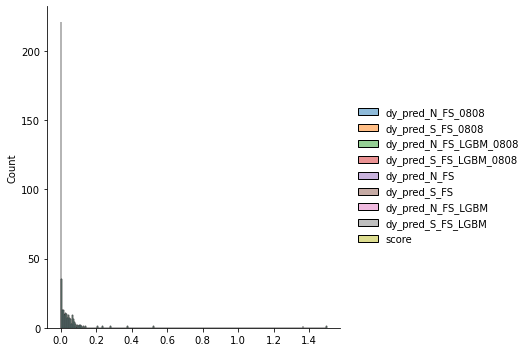

In [115]:
sns.displot(df_top_results)

In [93]:
df_recommend[df_recommend['score']<1][['Empresa','dy_label','score']].sort_values(by='score', ascending=False).iloc[:20]

Empresa  dy_label     score
90516                                LAVVI ON NM  0.018500  0.951008
34101                         Fer Heringer ON NM  0.002714  0.931559
18349  COMPANHIA DE GÁS DE SÃO PAULO - COMGÁS ON  0.110559  0.927905
68790                                Tegma ON NM  0.056549  0.922571
87561                              AFLUENTE T ON  0.009409  0.864028
90873                                AERIS ON NM  0.000000  0.746987
88691                            OMEGA GER ON NM  0.000410  0.711674
90756                               SIMPAR ON NM  0.002120  0.687412
31416                                 ESTRELA ON  0.000000  0.684493
60898              METALURGICA RIOSULENSE S/A PN  0.007512  0.676610
84269                           CCX CARVAO ON NM  0.000000  0.669849
88821                               SMILES ON NM  0.084568  0.666674
894                                  AES ELPA ON  0.000000  0.659112
61793                     SUL AMERICA SEGUROS ON  0.000000  0.658136
8233            BANCO MERCANTIL DO BRASIL S/A ON  0.012832  0.644473
46810                        MERCANTIL BRASIL ON  0.000000  0.643458
55822                          PORTOBELLO S/A ON  0.037061  0.635377
56538                          CELULOSE IRANI ON  0.030747  0.620158
21750                             CREMER S.A. ON  0.000000  0.612167
59402                                    ROMI ON  0.098703  0.609286

In [94]:
df_recommend[['Empresa','dy_label','score']].sort_values(by='score', ascending=False).iloc[:20]

Empresa  dy_label      score
77471                            TARPON INV ON NM  1.499944  16.124985
81671                                 VALID ON NM  0.000000  10.985904
37502                          Generalshopp ON NM  1.365604   9.825567
16022  CEB - COMPANHIA ENERGÉTICA DE BRASÍLIA PNA  0.236528   8.918884
79943                         BR PROPERTIES ON NM  0.523386   8.188811
90456                                  CELGPAR ON  0.022546   7.787830
34280                      INVESTIMENTOS BEMGE ON  0.379082   5.802196
80519                                  CEEE ON N1  0.125370   4.889316
30342                                     EMAE PN  0.278449   3.510203
31058                                 ENERGISA PN  0.000000   3.393460
45199                          LOPES BRASIL ON NM  0.002627   3.164577
8770       BANCO MERCANTIL DE INVESTIMENTOS SA ON  0.067590   2.823125
85879                               NUTRIPLANT ON  0.000000   2.753125
32848                                    FIBAM PN  0.000000   2.521187
22287    COMPANHIA DE SEGUROS ALIANÇA DA BAHIA ON  0.039326   2.438342
10381                             BANPARÁ S.A. ON  0.057058   2.420698
48242                          MONTEIRO ARANHA ON  0.071249   2.305018
17454                                   CELPE PNA  0.098863   1.746149
54165                                  PRONOR PNA  0.005050   1.658040
89818                             TAURUS ARMAS ON  0.000875   1.607919

In [79]:
dict_results['dy_pred_N_FS']

top5       top10      top20  top5_besst  top10_besst  \
dy_mean             0.295514    0.157455   0.218515    0.093763     0.095880   
pl_mean_last       15.569334  109.065393 -16.500250   25.421031    16.981079   
cotacao_mean_last  24.886132   42.117281  71.420526  102.944668    61.856759   

                   top20_besst  
dy_mean               0.062997  
pl_mean_last         11.590954  
cotacao_mean_last    38.360355

In [80]:
dict_results['dy_pred_N_FS_0808']

top5      top10      top20  top5_besst  top10_besst  \
dy_mean             0.402630   0.208528   0.137062    0.040342     0.059950   
pl_mean_last        9.509333  -4.666497   0.182703  -14.905257    -4.499309   
cotacao_mean_last  94.881464  78.327633  55.728814   93.078354    53.285299   

                   top20_besst  
dy_mean               0.058743  
pl_mean_last          2.191243  
cotacao_mean_last    33.702854

In [58]:
dict_results['dy_pred_S_FS']

top5       top10       top20  top5_besst  \
dy_mean              0.682296    0.398364    0.237452    0.079451   
pl_mean_last      -326.753568 -565.518820 -274.610596    7.291149   
cotacao_mean_last   18.030472   15.328279   17.585762   28.388228   

                   top10_besst  top20_besst  
dy_mean               0.056400     0.052413  
pl_mean_last         -6.486165     0.769817  
cotacao_mean_last    27.453410    34.066258

In [81]:
dict_results['dy_pred_S_FS_0808']

top5      top10       top20  top5_besst  top10_besst  \
dy_mean             0.363215   0.196724    0.113393    0.082999     0.052291   
pl_mean_last       10.665913   7.793511  131.831808    7.259843 -1991.052079   
cotacao_mean_last  48.451452  28.773769   21.912330   53.943462    33.001821   

                   top20_besst  
dy_mean               0.053773  
pl_mean_last       -996.299847  
cotacao_mean_last    27.465915

In [59]:
dict_results['dy_pred_N_FS_LGBM']

top5        top10        top20   top5_besst  \
dy_mean            0.273882     0.202343     0.110336     0.015702   
pl_mean_last       6.352125 -2074.111609 -1073.882576 -4024.223883   
cotacao_mean_last  9.667758    16.560642    38.532282    17.132076   

                   top10_besst  top20_besst  
dy_mean               0.010179     0.025958  
pl_mean_last      -3124.047609 -1556.813693  
cotacao_mean_last    21.308703    37.939003

In [82]:
dict_results['dy_pred_N_FS_LGBM_0808']

top5       top10       top20  top5_besst  \
dy_mean              0.376878    0.268873    0.144702    0.143990   
pl_mean_last         7.171719  -70.336986  373.848748    9.174374   
cotacao_mean_last  142.027610  144.456190  122.638866  135.218167   

                   top10_besst  top20_besst  
dy_mean               0.075277     0.045864  
pl_mean_last          9.641424    29.136309  
cotacao_mean_last    73.113294    44.806109

In [60]:
dict_results['dy_pred_S_FS_LGBM']

top5       top10      top20  top5_besst  top10_besst  \
dy_mean              0.733477    0.430554   0.242099    0.127277     0.096865   
pl_mean_last      -328.140136 -156.996648 -75.976366    6.936673     6.912466   
cotacao_mean_last   18.280214   20.146995  18.848338   24.830483    19.004584   

                   top20_besst  
dy_mean               0.085008  
pl_mean_last          9.613168  
cotacao_mean_last    19.325468

In [83]:
dict_results['dy_pred_S_FS_LGBM_0808']

top5       top10      top20  top5_besst  top10_besst  \
dy_mean             0.577619    0.377314   0.211706    0.062826     0.070977   
pl_mean_last        9.388667 -158.587611 -76.606048    5.692678     9.552785   
cotacao_mean_last  16.813651   13.970087  16.356007   14.243844    18.523410   

                   top20_besst  
dy_mean               0.074348  
pl_mean_last          9.775494  
cotacao_mean_last    17.846506

In [ ]:
dict_results['dy_pred_S_FS_LGBM']
dict_results['dy_pred_N_FS_LGBM_0808']

In [ ]:
def concat_results_

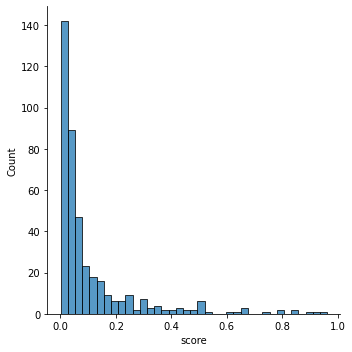

In [61]:
sns.displot(df_recommend[df_recommend['score']<1]['score'])

In [62]:
get_dy_metrics(df_recommend, 'dy_pred_N', 'besst_1', 1)

KeyError: 'dy_pred_N'

In [ ]:
get_dy_metrics(df_recommend, 'dy_pred_S', 'besst_1', 1)

top5      top10      top20  top5_besst  top10_besst  \
dy_mean             0.000390   0.000200   0.000316    0.000793     0.003467   
pl_mean_last       78.592542  45.383646  96.175387  375.870701   190.634370   
cotacao_mean_last   3.330993   4.564679   5.487364    8.992739    15.189313   

                   top20_besst  
dy_mean               0.006265  
pl_mean_last         28.935587  
cotacao_mean_last    22.822770

In [ ]:
df_recommend[df_recommend['besst_1']==1].iloc[:20]

Empresa  Papel Papel_root  besst_1  \
8770       BANCO MERCANTIL DE INVESTIMENTOS SA ON  BMIN3       BMIN      1.0   
22287    COMPANHIA DE SEGUROS ALIANÇA DA BAHIA ON  CSAB3       CSAB      1.0   
11276                          CONSORCIO ALFA PNA  BRGE5       BRGE      1.0   
16022  CEB - COMPANHIA ENERGÉTICA DE BRASÍLIA PNA  CEBR5       CEBR      1.0   
80519                                  CEEE ON N1  EEEL3       EEEL      1.0   
30342                                     EMAE PN  EMAE4       EMAE      1.0   
84754                          BBSEGURIDADE ON NM  BBSE3       BBSE      1.0   
86735                           AES TIETE E PN N2  TIET4       TIET      1.0   
8233             BANCO MERCANTIL DO BRASIL S/A ON  BMEB3       BMEB      1.0   
76469                                      BRB ON  BSLI3       BSLI      1.0   
90336                             BOA VISTA ON NM  BOAS3       BOAS      1.0   
17454                                   CELPE PNA  CEPE5       CEPE      1.0   
894                                   AES ELPA ON  AELP3       AELP      1.0   
90606                                   PADTEC ON  PDTC3       PDTC      1.0   
61793                      SUL AMERICA SEGUROS ON  SASG3       SASG      1.0   
23540                                  COSERN PNB  CSRN6       CSRN      1.0   
35533  DUKE ENERGY INT,GERAÇÃO PARANAPANEMA SA PN  GEPA4       GEPA      1.0   
1252                                 AFLUENTE PNA  AFLU5       AFLU      1.0   
55643                          PORTO SEGURO SA ON  PSSA3       PSSA      1.0   
55464                                Parana PN N1  PRBC4       PRBC      1.0   

       dy_label  pl_mean_last  cotacao_mean_last   dy_pred_N   dy_pred_S  \
8770   0.067590     25.274933          20.901453   -0.759897   -0.279980   
22287  0.039326     52.537032          61.940998    0.354277   -0.063198   
11276  0.000000     33.709897           9.609396  172.735564   69.920493   
16022  0.236528      1.067315          14.443704    1.521311    6.299068   
80519  0.125370     14.515980         407.827790  -21.079663    1.930914   
30342  0.278449      7.246631          36.501051    0.024253   24.217549   
84754  0.091351      8.390291          24.214831    0.020359    0.002261   
86735  0.038668      6.630114           3.415507   43.694807   54.915933   
8233   0.012832      7.547568          16.450384  129.991554  166.160866   
76469  0.068689     12.891027          23.262474   -0.641628   -0.032425   
90336  0.000248     20.325899           7.181489    0.029807    0.084299   
17454  0.098863      6.969446          29.329258    0.434527    0.495954   
894    0.000000      8.490000           1.995455  130.360368  138.576353   
90606  0.000000     10.193397           5.944383  169.890425   59.194558   
61793  0.000000      0.029401           0.980000  317.088831  141.082210   
23540  0.075212     14.558927          34.835215   -0.166797   -0.092064   
35533  0.064574   -412.790920          29.485984    0.104803   -0.024265   
1252   0.008751      8.929337           4.951464    0.874541   -0.173008   
55643  0.051539     11.668061          19.423999    0.027394   -0.158104   
55464  0.001949    393.634734          14.512262  189.387347  221.852243   

       dy_pred_N_FS  dy_pred_S_FS  dy_pred_N_FS_LGBM  dy_pred_S_FS_LGBM  \
8770      82.969685     -0.032572         -30.522439           0.031145   
22287     64.700520     -0.056323         -23.557650           0.032369   
11276      3.979692     -0.023446           0.792851           0.017284   
16022      3.162517     16.563801          -7.500894          10.466093   
80519      2.658401     -0.800735           0.768991           0.054701   
30342      1.517338    -10.054643          -1.355035          16.213358   
84754      1.233072     -0.084921          -0.247172           0.123338   
86735      1.170421      0.014586          -1.357101           0.023871   
8233       1.052761     -0.014868           0.130834           0.017564   
76469      0.6

In [ ]:
path = '../data/03_models/out/'
model_name = '2023-08-05_LGBMRegressor_Normalizer()_feat_selection.pkl'

with open(path + model_name, 'rb') as file:
        lgb_regressor = pickle.load(file)

df_to_pred['dy_pred'] = lgb_regressor.predict(X_to_pred[cols_to_train])

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- c5y_mean_trend
- patrliq_mean_trend
- pebit_mean_mean
- pib_dolarizado_trend
- power_stabil
- ...
Feature names seen at fit time, yet now missing:
- cotacao_mean_mean
- cotacao_mean_ref_std
- dy_mean_std
- dy_spread
- evebit_mean_mean
- ...



ValueError: X has 26 features, but Normalizer is expecting 29 features as input.

In [ ]:
df_to_pred[df_to_pred['besst_1']==1].sort_values(by='dy_pred', ascending=False).iloc[0:50][['Empresa','dy_label','dy_pred']]

In [ ]:
path = '../data/03_models/out/'

model_name = f'{date.today()}_LGBMRegressor_Normalizer().pkl'

lgb_model = load_model(path, model_name)

xgb_feature_importance = get_feature_importances(xgb_model, 'XGB', X.columns.to_list())

In [ ]:
print(len(cols_to_train_lgmb))

48


In [ ]:
X.columns.to_list()

['dy_mean_last',
 'dy_median_last',
 'dy_median_max',
 'dy_spread',
 'dy_median_min',
 'dy_median_ref_min',
 'dy_mean_std',
 'power_min',
 'roe_mean_trend',
 'besst_1',
 'Tipo_PN',
 'Tipo_ON',
 'power_buy_flag',
 'power_stabil_delta',
 'dolar_comercial_trend',
 'cotacao_mean_mean',
 'encoded_sectors',
 'cotacao_mean_ref_mean',
 'besst_2',
 'cotacao_max_ref_max',
 'power_stabil',
 'year_last',
 'roe_mean_last',
 'cotacao_mean_last',
 'patrliq_mean_mean',
 'patrliq_mean_last',
 'liq2m_mean_mean',
 'dolar_comercial_last',
 'liqc_mean_mean',
 'liq2m_mean_last',
 'cotacao_mean_ref_std',
 'liqc_mean_last',
 'selic_last',
 'ibovespa_spread_relevance',
 'ibovespa_spread',
 'dolar_comercial_mean',
 'ipca_mean',
 'pib_dolarizado_mean',
 'preco_do_petroleo_mean',
 'ibovespa_mean',
 'igpm_mean',
 'preco_do_petroleo_trend',
 'pib_dolarizado_trend',
 'ipca_trend',
 'ibovespa_trend',
 'igpm_trend',
 'selic_mean',
 'month_last',
 'divbpatr_mean_mean',
 'euro_mean',
 'c5y_mean_mean',
 'divbpatr_max_ref